# SEISMO-VRE for a multiparametric and multidisciplinary analysis of an earthquake  
Except where otherwise noted, this Jupyter Notebook is made available under the GPL-3.0 license. For details, please see the `LICENSE` file in the main directory.
# PYTHON Version

## MINI ABSTRACT  

The study presents the development of a Virtual Research Environment (VRE) for analysing an earthquake using a multiparametric and multidisciplinary approach. The case study of the 2016-2017 Amatrice-Norcia (Italy) seismic sequence was selected as an example. Implemented through Jupyter Notebooks, the VRE enables researchers to reproduce analyses, modify parameters, and visualise results interactively. It leverages the European Plate Observing System (EPOS) platform, which integrates diverse geophysical datasets. The system accesses earthquake data via EPOS APIs and could potentially be deployed as software within the EPOS portal in the future.

## IMPLEMENTATION OVERVIEW
### Data 
The VRE at this preliminary stage of implementation uses:
1. **[Lithosphere](#Lithospheric-analysis):** earthquake catalogue retrieved by EPOS; [GNSS station positions retrieved by EPOS](#Analysis-of-vatiations-of-plates-movements-from-EPOS-GNSS-Positions);  
2. **[Atmosphere](#Atmospheric-analysis):** Climatological measurements from the MERRA-2 archive by NASA (parameters: SO_2, dimethyl sulphide, aerosol optical thickness, CO, Surface Air Temperature, relative humidity, Surface Latent Heat Flux, Total Precipitation);
3. **[Ionosphere](#Ionospheric-analysis):**  Swarm three identical satellite magnetic data 

### Analyses workflow 
1. [Lithosphere](#Lithospheric-analysis)  
2. [Atmospheric analysis](#Atmospheric-analysis)
3. [Ionosphere](#Ionospheric-analysis)
4. [Comparison of the three Geo-layers](#Comparison-of-Lithosphere-Atmosphere-and-Ionosphere-analyses).

### Reconfigurable parameters
The VRE is reconfigurable for another target earthquake (possible limitation for events close to -180 or +180 longitude) changing:
1. **Earthquake origin time:** EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second;
2. **earthquake magnitude:** EQ_mag;
3. **Epicentral coordinates:** epilat, epilon.
4. **Hypocentral depth:** EQ_depth
5. **Fault strike:** Fault_strike (this is the angle of orientation of the fault determined from one of the two nodal planes 
It's also possible to change the time to be analysed before and after the target earthquake (in days):
6. **day before the earthquake:** day_before;
7. **day after the earthquake:** day_after

In [1]:
# Global variables initialization

# Earthquake origin time
EQ_year = 2016
EQ_month = 8
EQ_day = 24
EQ_hour = 1
EQ_minute = 36
EQ_second = 32

# Epicenter latitude and longitude
epilat = 42.6980
epilon = 13.2340

# Mainshock magnitude and depth
EQ_mag = 6.5
EQ_depth = 10

# Fault strike
# Here is inserted a mean strike of the two main faults: Amatrice 155 and Norcia 151.
# This strike must be a positive value.
Fault_strike = 153

# Time windows
day_before = 8 * 30  # example,  8*30 days before
day_after = 0

In [13]:
# pip install -r requirements.txt
!pip install cartopy haversine

  Using cached haversine-2.9.0-py2.py3-none-any.whl.metadata (5.8 kB)
Using cached haversine-2.9.0-py2.py3-none-any.whl (7.7 kB)


# Lithospheric analysis 
## step 1
1. Lithospheric analysis
1.1  
we retrieve the seismic catalogue to study the Lithosphere from the EPOS Platform

In [3]:
from datetime import datetime, timedelta
import requests
import time

# Compute time in datetime format
EQ_time = datetime(EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second)
time_start = EQ_time - timedelta(days=day_before)
time_end = EQ_time + timedelta(days=day_after)

# Definition of the radius (approx Dobrovolsky)
radius_Dobrovolsky = 10 ** (0.43 * EQ_mag) / 111

# Compute latitude/longitude coordinates for filtering
min_lat = epilat - radius_Dobrovolsky - 5
max_lat = epilat + radius_Dobrovolsky + 5
min_lon = epilon - radius_Dobrovolsky - 5
max_lon = epilon + radius_Dobrovolsky + 5

# Minimum magnitude to retrieve from the catalog
EQ_min_mag = 1.0

# List to store results
EQ = []

# Daily loop from time_start to time_end
current_time = time_start
max_attempts = 3
wait_seconds = 2
while current_time < time_end:
    # End of interval: add 23 hours, 59 minutes, 59 seconds
    time_tba_end = current_time + timedelta(hours=23, minutes=59, seconds=59)

# Build URL with the updated time window
    url = (f"https://www.seismicportal.eu/fdsnws/event/1/query?"
           f"starttime={current_time.strftime('%Y-%m-%dT%H:%M:%SZ')}"
           f"&endtime={time_tba_end.strftime('%Y-%m-%dT%H:%M:%SZ')}"
           f"&minmagnitude={EQ_min_mag:.1f}"
           f"&minlatitude={min_lat:.4f}&maxlatitude={max_lat:.4f}"
           f"&minlongitude={min_lon:.4f}&maxlongitude={max_lon:.4f}"
           "&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204")
    print(url)
    success = False
    attempts = 0

    while not success and attempts < max_attempts:
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                EQ_p = response.json()
                success = True
            elif response.status_code == 204:
                print(f"[{current_time.date()}] Nessun evento sismico.")
                EQ_p = []
                success = True
            else:
                print(f"[{current_time.date()}] Errore HTTP: {response.status_code}")
                attempts += 1
                time.sleep(wait_seconds)
        except requests.exceptions.RequestException as e:
            print(f"[{current_time.date()}] Tentativo {attempts+1} fallito: {e}")
            attempts += 1
            time.sleep(wait_seconds)

    if not success:
        print(f"[{current_time.date()}] Fallimento dopo {max_attempts} tentativi.")
        EQ_p = None

    EQ.append(EQ_p)

    # Move to the next day (00:00)
    current_time += timedelta(days=1)
    time.sleep(1)# Display of the retrieved data
# print(EQ)

https://www.seismicportal.eu/fdsnws/event/1/query?starttime=2015-12-28T01:36:32Z&endtime=2015-12-29T01:36:31Z&minmagnitude=1.0&minlatitude=32.0788&maxlatitude=53.3172&minlongitude=2.6148&maxlongitude=23.8532&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204
https://www.seismicportal.eu/fdsnws/event/1/query?starttime=2015-12-29T01:36:32Z&endtime=2015-12-30T01:36:31Z&minmagnitude=1.0&minlatitude=32.0788&maxlatitude=53.3172&minlongitude=2.6148&maxlongitude=23.8532&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204
https://www.seismicportal.eu/fdsnws/event/1/query?starttime=2015-12-30T01:36:32Z&endtime=2015-12-31T01:36:31Z&minmagnitude=1.0&minlatitude=32.0788&maxlatitude=53.3172&minlongitude=2.6148&maxlongitude=23.8532&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204
https://www.seismicportal.eu/fdsnws/event/1/query?starttime=2015-12-31T01:36:32Z&endtime=2016-01-01T01:36:31Z&minmagnitude=1.0&minlatitude=

The following part, convert the earthquake catalogue in an array with the ZMap (Wiemer, 2001) standard, that  is:
longitude | latitude | year | month | day | magnitude | depth | hour | minute | second

<b> References: </b>
Wiemer, S. A Software Package to Analyze Seismicity: ZMAP. Seismological Research Letters 2001, 72, 373–382, doi:10.1785/gssrl.72.3.373.



E:\Software_extra\anaconda3\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


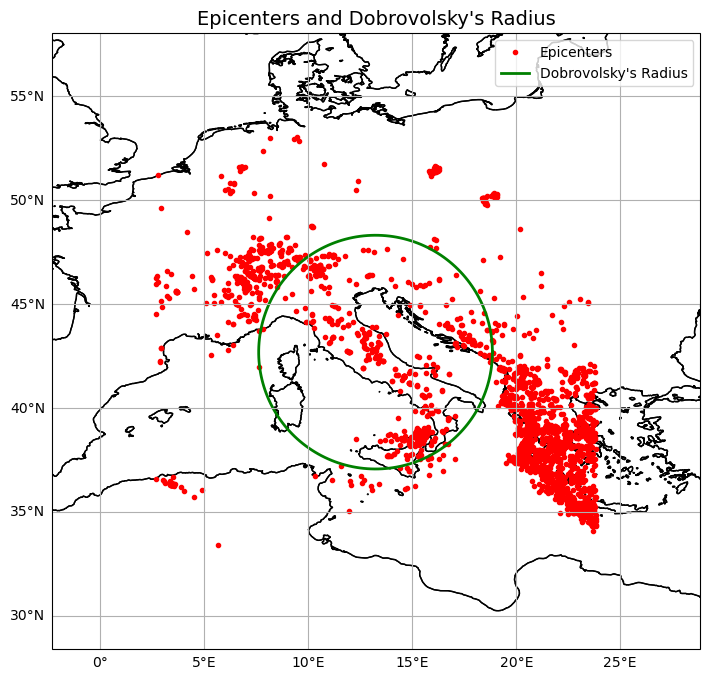

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------------------
# Process data to create the EQ_new matrix
# ------------------------------------------------------------------------------

# EQ_new will be built as a list of rows and then converted to a NumPy array.
# Each row has 10 columns:
# [longitude, latitude, year, month, day, magnitude, -depth, hour, minute, second]

eq_new_rows = []  # List for accumulating rows

# Loop over records in EQ
for entry in EQ:
    if isinstance(entry, dict):  # Check that it is a valid dictionary
        features = entry.get("features", [])
        for feature in features:
            geometry = feature.get("geometry", {})
            properties = feature.get("properties", {})

            hypocenter = geometry.get("coordinates", [np.nan, np.nan, np.nan])
            EQ_magnitude = properties.get("mag", np.nan)
            EQ_origin_time = properties.get("time", "")

            if len(EQ_origin_time) >= 19:
                new_time_str = EQ_origin_time[0:10] + " " + EQ_origin_time[11:19]
                try:
                    dt = datetime.strptime(new_time_str, '%Y-%m-%d %H:%M:%S')
                except ValueError:
                    dt = None
            else:
                dt = None

            if dt is not None:
                row = [
                    hypocenter[0],
                    hypocenter[1],
                    dt.year,
                    dt.month,
                    dt.day,
                    EQ_magnitude,
                    -hypocenter[2],
                    dt.hour,
                    dt.minute,
                    dt.second
                ]
                eq_new_rows.append(row)
    else:
        continue
# Convert the list into a NumPy array
EQ_new = np.array(eq_new_rows)

# Compute map limits based on epicenters (with 5° padding)
min_lon, max_lon = np.min(EQ_new[:, 0]), np.max(EQ_new[:, 0])
min_lat, max_lat = np.min(EQ_new[:, 1]), np.max(EQ_new[:, 1])

# -----------------------------------------------------------------------------------
# Create the figure with a geographic map and high‑resolution coastlines
# -----------------------------------------------------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add global coastlines with higher resolution (10 m)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Retrieve coastline coordinates
coastline = cfeature.COASTLINE.with_scale('10m')

# Set the map extent (adding 5° padding to the bounds)
ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

# Add high‑resolution coastlines (10 m)
ax.coastlines(resolution='10m', linewidth=1)

# Add an additional detail, such as national borders
#ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='gray')

# -----------------------------------------------------------------------------------
# Plot of the epicentres
# -----------------------------------------------------------------------------------
ax.plot(EQ_new[:, 0], EQ_new[:, 1], 'or', markersize=3, label='Epicenters', transform=ccrs.PlateCarree())

# -----------------------------------------------------------------------------------
# Compute and plot the two circles (parameterised around the epicentre)
# -----------------------------------------------------------------------------------
t = np.linspace(0, 2 * np.pi, 200)

# Dobrovolsky circle
circle_lon1 = epilon + radius_Dobrovolsky * np.cos(t)
circle_lat1 = epilat + radius_Dobrovolsky * np.sin(t)
ax.plot(circle_lon1, circle_lat1, '-g', linewidth=2, label="Dobrovolsky's Radius", transform=ccrs.PlateCarree())

# -----------------------------------------------------------------------------------
# Add grid and configure axes
# -----------------------------------------------------------------------------------
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False  # Remove labels from the top and right edges

# Add title and legend
plt.title("Epicenters and Dobrovolsky's Radius", fontsize=14)
ax.legend(loc='upper right')

# Display the map
plt.show()

# Selection of earthquakes of interest
In the following lines, only the most interesting earthquakes are selected. In fact, we will consider a circular area defined by Dobrovolsky's Radius (km) = $10^{0.43 \times MAG}$ (Dobrovolsky et al., 1979). This is one of the possible areas that define the preparation of an earthquake, but it's widely used, and it corresponds to the distance where the seismic shaking is equal to the terrestrial tidal deformation.

In addition, we need to select only the earthquakes with a magnitude equal to or greater than the completeness magnitude of the earthquake catalogue.  
Last but not least, a selection of shallow earthquakes can be applied as deeper events are unlikely related to the interactions with the atmosphere and ionosphere. 

<b> References: </b>  
Dobrovolsky, I.P.; Zubkov, S.I.; Miachkin, V.I. Estimation of the Size of Earthquake Preparation Zones. PAGEOPH 1979, 117, 1025–1044, doi:10.1007/BF00876083.


In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance (in km) between the point (lat1, lon1) and (lat2, lon2).
    Parameters:
    lat1, lon1 – coordinates of the target point (single values)
    lat2, lon2 – coordinates of the events (can be arrays)
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371.0  # Mean Earth radius in km
    return R * c/111

#Compute distances from the target source for each event
# distance(epilat, epilon, EQ_new(:,2), EQ_new(:,1))
distance_from_target_EQ = haversine_distance(epilat, epilon, EQ_new[:, 1], EQ_new[:, 0])

# Filter events within the Dobrovolsky radius
mask_radius = distance_from_target_EQ <= radius_Dobrovolsky
EQ_sel = EQ_new[mask_radius, :]
distance_from_target_EQ = distance_from_target_EQ[mask_radius]

Completeness_magnitude = 2.0
max_depth = 50

# Filter events by completeness magnitude 
mask_mag = EQ_sel[:, 5] >= Completeness_magnitude
EQ_sel = EQ_sel[mask_mag, :]
distance_from_target_EQ = distance_from_target_EQ[mask_mag]

# Filter by maximum depth
mask_depth = EQ_sel[:, 6] <= max_depth
EQ_sel = EQ_sel[mask_depth, :]
distance_from_target_EQ = distance_from_target_EQ[mask_depth]

# At this point, EQ_sel contains the filtered events, and distance_from_target_EQ holds their corresponding distances.

# Calculus of Cumulative Benioff Strain 
The Benioff cumulative strain is computed according to the original formulation of Benioff:  
$S(t) = \sum_{i}^{N}{\sqrt{E_i}}$  
where S is the Benioff Strain at time t and E_i is the earthquake energy calculated with the Richter equation:  
$E_i(J) = 10^{(1.5 \cdot M_i + 4.8)}$  
where M is the magnitude of the event i

<b> Reference: </b>  
Benioff, H. Global Strain Accumulation and Release as Revealed by Great Earthquakes. GSA Bulletin 1951, 62, 331–338, doi:10.1130/0016-7606(1951)62[331:GSAARA]2.0.CO;2.

586


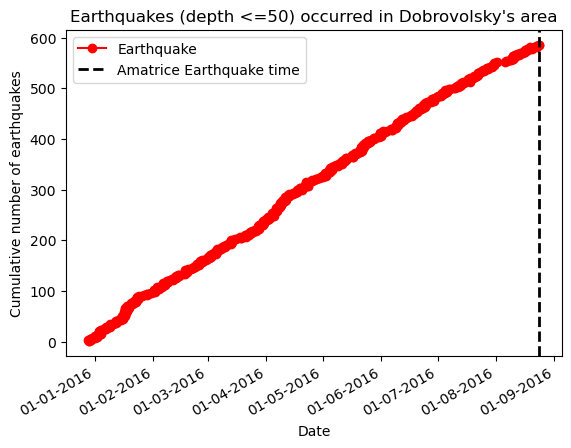

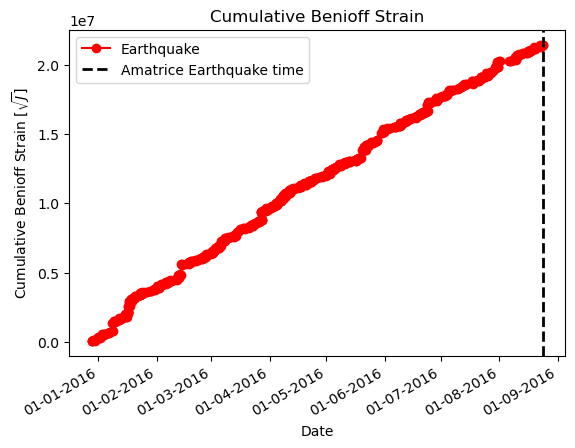

In [9]:
import matplotlib.dates as mdates
import datetime

# Number of selected events
n_events = EQ_sel.shape[0]
print(n_events)
# Create the cumulative vector equivalent to np.arange in Python:
cumulative_number = np.arange(1, n_events + 1)

# Build the date array from columns [year, month, day, hour, minute, second]
# usava: datenum([EQ_sel(:,3:5), EQ_sel(:,8:10)])
# In Python the corresponding indices are [2, 3, 4, 7, 8, 9]
time_EQ_sel = np.array([
    datetime.datetime(int(row[2]), int(row[3]), int(row[4]), int(row[7]), int(row[8]), int(row[9]))
    for row in EQ_sel
])

# ---------------------------------------------------------------------------
# First plot: Cumulative number of earthquakes over time
# ---------------------------------------------------------------------------
fig, ax = plt.subplots()

ax.plot(time_EQ_sel, cumulative_number, '-or', label='Earthquake')

# Impostazione del formato della data sull'asse x (dd-mm-yyyy)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()  # Ruota le date per migliore leggibilità

# Vertical line marking the reference event (e.g., Amatrice)
ax.axvline(x=EQ_time, linestyle='--', linewidth=2, color='k', 
           label='Amatrice Earthquake time')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative number of earthquakes')

# The title includes max_depth; the apostrophe is escaped correctly
ax.set_title(f"Earthquakes (depth <={max_depth}) occurred in Dobrovolsky's area")
ax.legend(loc='upper left')
plt.show()


# ---------------------------------------------------------------------------
# Compute cumulative Benioff Strain
# ---------------------------------------------------------------------------
# EQ_energy = 10^(1.5*EQ_sel(:,6)+4.8)
# Magnitude is stored in column 5 (0‑based) in Python
EQ_energy = 10 ** (1.5 * EQ_sel[:, 5] + 4.8)

# Compute the contribution: cumulative sum of sqrt(EQ_energy)
# Use np.cumsum instead of an explicit loop
EQ_sqrt_energy = np.cumsum(np.sqrt(EQ_energy))

# ---------------------------------------------------------------------------
# Second plot: Cumulative Benioff Strain over time
# ---------------------------------------------------------------------------
fig2, ax2 = plt.subplots()

ax2.plot(time_EQ_sel, EQ_sqrt_energy, '-or', label='Earthquake')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig2.autofmt_xdate()
ax2.axvline(x=EQ_time, linestyle='--', linewidth=2, color='k', label='Amatrice Earthquake time')

ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Benioff Strain [$\\sqrt{J}$]')
ax2.set_title('Cumulative Benioff Strain')
ax2.legend(loc='upper left')
plt.show()


# Earthquake released energy as a function of the distance to the target earthquake
In the following, the earthquake released energy is weighted with the square distance to the incoming earthquake, according to the parameter $E_S$ introduced by prof. Katsumi Hattori (e.g., Hattori et al., 2013):  
$E_S = \sum_i{E_i \over r^2}$  
The parameter $E_S$ is calculated on all i-th events occurred in a single day.  
The concept is that an earthquake that happened closer to the future larger target is more important than one which is far.

<b> References: </b>  
Hattori, K.; Han, P.; Yoshino, C.; Febriani, F.; Yamaguchi, H.; Chen, C.-H. Investigation of ULF Seismo-Magnetic Phenomena in Kanto, Japan During 2000–2010: Case Studies and Statistical Studies. Surv Geophys 2013, 34, 293–316, doi:10.1007/s10712-012-9215-x.


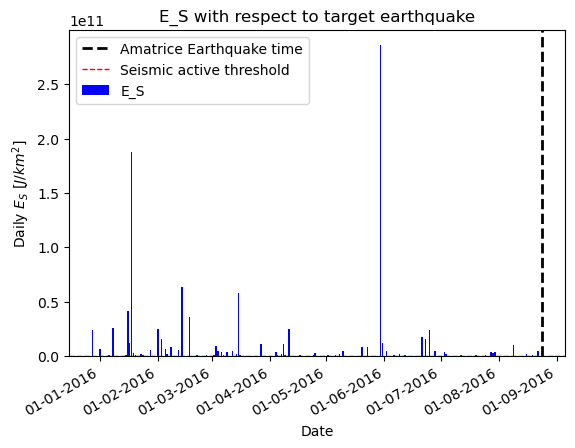

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# =============================================================================
# Compute EQ_energy_for_ES
# =============================================================================
# Compute EQ_energy_for_ES as EQ_energy divided by distance_from_target_EQ squared
EQ_energy_for_ES = EQ_energy / (distance_from_target_EQ**2)

# =============================================================================
# Define analysis period
# =============================================================================
#time_start and time_end can be defined based on the available data.
# For instance, using the minimum and maximum of time_EQ_sel:
time_start = min(time_EQ_sel)
time_end = max(time_EQ_sel)

# day_start = time_start.date();  day_end = time_end.date()
# In Python we extract only the date (no time component)
day_start = time_start.date()
day_end = time_end.date()

number_of_analysed_days = (day_end - day_start).days + 1

# =============================================================================
# Daily computation of E_S
# =============================================================================
# ES_Daily: for each day store [date, daily E_S sum]
# Assumes EQ_sel[:,2:5] contains [year, month, day, ...]
ES_Daily = []
current_day = day_start
while current_day <= day_end:
# Build a mask that selects events matching the current year, month, and day
    mask = (
        (EQ_sel[:, 2].astype(int) == current_day.year) &
        (EQ_sel[:, 3].astype(int) == current_day.month) &
        (EQ_sel[:, 4].astype(int) == current_day.day)
    )
    daily_ES = np.sum(EQ_energy_for_ES[mask])
    ES_Daily.append((current_day, daily_ES))
    current_day += timedelta(days=1)

# Separate dates and values for plotting
daily_dates = [x[0] for x in ES_Daily]
daily_ES = [x[1] for x in ES_Daily]

# =============================================================================
# Bar plot: daily E_S
# =============================================================================
fig, ax = plt.subplots()

# Bar plot: dates are correctly interpreted by matplotlib
ax.bar(daily_dates, daily_ES, color='blue', label='E_S')

# Format the x‑axis to show dates as dd‑mm‑yyyy
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()

# Vertical line for the reference event (EQ_time)
ax.axvline(x=EQ_time, linestyle='--', linewidth=2, color='k', label='Amatrice Earthquake time')
# Horizontal line for the seismically‑active threshold (1e8)
ax.axhline(y=1e8, linestyle='--', linewidth=1, color='r', label='Seismic active threshold')

ax.set_xlabel('Date')
ax.set_ylabel('Daily $E_S$ [$J/km^2$]')
ax.set_title('E_S with respect to target earthquake')
ax.legend(loc='upper left')
plt.show()

# =============================================================================
# Compute cumulative E_S
# =============================================================================
# Create cumulative_ES with one extra leading row—start at day_start − 1 with value 0, then progressively add the daily ES values.
cumulative = 0
cumulative_ES = []
# Insert first row: the day before day_start with value 0
cumulative_ES.append((day_start - timedelta(days=1), 0))
for d, val in zip(daily_dates, daily_ES):
    cumulative += val
    cumulative_ES.append((d, cumulative))

# Separate cumulative dates and values for plotting
cum_dates = [x[0] for x in cumulative_ES]
cum_values = [x[1] for x in cumulative_ES]

# =============================================================================
# Line plot: cumulative E_S
# =============================================================================
fig2, ax2 = plt.subplots()
ax2.plot(cum_dates, cum_values, '-ob', linewidth=1.5, label='Daily E_S')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig2.autofmt_xdate()
ax2.axvline(x=EQ_time, linestyle='--', linewidth=2, color='k', label='Amatrice Earthquake time')

ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative $E_S$ [$J/km^2$]')
ax2.set_title('Cumulative E_S')
ax2.legend(loc='upper left')
plt.show()


# Analysis of vatiations of plates movements from EPOS GNSS Positions 
The following code extract the data from EPOS GNSS data service, searching for available stations inside the square inscribed in the Dobrovolskys's circle and then process the data calculating the differences between eventual GNSS stations along transects of the target fault strike.

In [11]:
from datetime import datetime, timedelta
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.io.shapereader as shpreader

# ---------------------------------------------------------------------------
# Compute dates and time boundaries
# ---------------------------------------------------------------------------
# EQ_time: convert components into a datetime object
EQ_time = datetime(EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second)

# Calcola time_start e time_end a partire dall’evento
time_start = EQ_time - timedelta(days=day_before)
time_end   = EQ_time + timedelta(days=day_after)

# Extract year, month and day for time_start and time_end
year_start, month_start, day_start = time_start.year, time_start.month, time_start.day
year_end,   month_end,   day_end   = time_end.year,   time_end.month,   time_end.day

# ---------------------------------------------------------------------------
# Compute the Dobrovolsky radius and geographic bounds
# ---------------------------------------------------------------------------
# radius_Dobrovolsky(degree):
#   radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
radius_Dobrovolsky = 10**(0.43 * EQ_mag) / 111

# Define the bounding box for the GNSS-station search
min_lat = epilat - radius_Dobrovolsky / np.sqrt(2)
max_lat = epilat + radius_Dobrovolsky / np.sqrt(2)
min_lon = epilon - radius_Dobrovolsky / np.sqrt(2)
max_lon = epilon + radius_Dobrovolsky / np.sqrt(2)

# ---------------------------------------------------------------------------
# Retrieve the list of GNSS stations
# ---------------------------------------------------------------------------
# Build the URL for data retrieval (formatted with four decimal places)
url_station_list = (
    f"https://gnssproducts.epos.ubi.pt/glass/products/velocities/geojson/SGO-EPND/"
    f"{min_lon:.4f}/{min_lat:.4f}/{max_lon:.4f}/{max_lat:.4f}/"
)

# Perform the HTTP request and parse the JSON response
GNSS_station_list = requests.get(url_station_list).json()

data_from_GNSS = []  # List to store the data for each station

if "features" in GNSS_station_list and len(GNSS_station_list["features"]) > 0:
    features = GNSS_station_list["features"]
    number_of_GNSS_stations = len(features)
    # Preallocate an array for the coordinates (number of stations × 2)
    coordinates_of_GNSS = np.full((number_of_GNSS_stations, 2), np.nan)
    
    for i, feature in enumerate(features):
        props = feature["properties"]
        # Extract station longitude and latitude
        lon_station = props["Longitude"]
        lat_station = props["Latitude"]
        coordinates_of_GNSS[i, :] = [lon_station, lat_station]
        
        station_id = props["GNSS Station ID"]
        # Build the URL to retrieve the station’s time-series data, formatting the dates as YYYY-MM-DD
        url_station_data = (
            f"https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/products/timeseries/"
            f"{station_id}/SGO-EPND/weekly/enu/json/?epoch_start="
            f"{year_start}-{month_start:02d}-{day_start:02d}&epoch_end="
            f"{year_end}-{month_end:02d}-{day_end:02d}"
        )
        
        # Recupera i dati della stazione
        GNSS_data = requests.get(url_station_data).json()
        
# If the response is not: No data available
        if GNSS_data != "No data available":
            if "results" in GNSS_data:
                results = GNSS_data["results"]
                # Prepare a list for the extracted data: each row stores [epoch, dn, de, du]
                extracted_data = []
                for entry in results:
# The epoch timestamp was originally converted with datenum.
# In Python you can leave the string as-is or convert it to a datetime object.
                    epoch_str = entry["epoch"]
                    dn = entry["dn"]
                    de = entry["de"]
                    du = entry["du"]
                    extracted_data.append([epoch_str, dn, de, du])
                # Save the station data (coordinates and time series)
                data_from_GNSS.append({
                    "coordinates": coordinates_of_GNSS[i, :],
                    "data": np.array(extracted_data)
                })

# Build an array with coordinates of all stations (for plotting)
if len(data_from_GNSS) > 0:
    coordinates_for_map = np.array([item["coordinates"] for item in data_from_GNSS])
else:
    coordinates_for_map = np.empty((0, 2))

# ---------------------------------------------------------------------------
# Plot: map with coastline, epicentre, GNSS stations and Dobrovolsky circle
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())

# Add global coastlines with higher resolution (10 m)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Retrieve coastline coordinates
coastline = cfeature.COASTLINE.with_scale('10m')

# Set the map extent (adding 5° padding to the bounds)
ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

# Add high‑resolution coastlines (10 m)
ax.coastlines(resolution='10m', linewidth=1)

# Add an additional detail, such as national borders
#ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='gray')

# -----------------------------------------------------------------------------------
# Compute and plot the two circles (parameterised around the epicentre)
# -----------------------------------------------------------------------------------
t = np.linspace(0, 2 * np.pi, 200)
# Dobrovolsky Circle
circle_lon1 = epilon + radius_Dobrovolsky * np.cos(t)
circle_lat1 = epilat + radius_Dobrovolsky * np.sin(t)
ax.plot(circle_lon1, circle_lat1, '-g', linewidth=2, label="Dobrovolsky's Radius", transform=ccrs.PlateCarree())

# -----------------------------------------------------------------------------------
# Add grid and configure axes
# -----------------------------------------------------------------------------------
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False  # Remove labels from the top and right edges

# Plot of the earthquake epicentre
ax.plot(epilon, epilat, 'ob', markersize=10, markerfacecolor='b', label='Earthquake',transform=ccrs.PlateCarree())

# Plot of the GNSS stations (if available)
if coordinates_for_map.shape[0] > 0:
    ax.plot(coordinates_for_map[:, 0], coordinates_for_map[:, 1], '^r', label='GNSS stations',transform=ccrs.PlateCarree())

# Set axes with 5‑degree padding beyond limits
plt.axis([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Plot of the GNSS stations (if available)
plt.show()



The following block calculates some basic parameters to analyse the data from the GNSS stations.  
In particular, the **angular tolerance** is a parameter to consider aligning two different stations eventually with respect to the fault direction (or its perpendicular direction for transect). The **maximum distance** is the segment, along the fault direction, to be investigated and it's defined as 10 times the broken fault segment.

In [14]:
import numpy as np
from haversine import haversine, Unit
import numpy as np
from pyproj import Geod
# Parameters
angular_tolerance = 5  # degrees, maximum angular difference
distance_GNSS_station_EQ = []
# Suppose coordinates_for_map is a NumPy array of shape (N, 2): columns are [longitude, latitude]
# epilat and epilon are the epicenter coordinates: latitude and longitude
# Compute distance between each GNSS station and the earthquake epicenter
# The simple multiplication by 111 (approximate km/degree) assumes a spherical Earth model
# For more precision, libraries like geopy or haversine can be used.
coordinates_for_map = np.column_stack((coordinates_for_map[:, 0], coordinates_for_map[:, 1]))
epicenter = epilon, epilat                                                
g= Geod(ellps="WGS84")
for coord in coordinates_for_map:
        GNSS_point = (coord[0], coord[1])
        az1, az2, distance_m = g.inv(coord[0], coord[1], epilon, epilat)
        distance_km = distance_m/1000
        distance_GNSS_station_EQ.append(distance_km)
distance_GNSS_station_EQ = np.array(distance_GNSS_station_EQ)
# Compute angle from each station to epicenter
angle_to_EQ = np.degrees(
    np.arctan2(coordinates_for_map[:, 1] - epilat, coordinates_for_map[:, 0] - epilon)
)
# Length of the broken fault, based on EQ_depth (km)
Length_of_broken_fault = 3 * EQ_depth  # according to Doglioni et al., Sci. Rep., 2015
# Maximum distance to search (10 times half the broken fault length)
Maximum_distance = 10 * Length_of_broken_fault / 2  # in km
print(f"Maximum distance: {Maximum_distance:.2f} km")


Maximum distance: 150.00 km


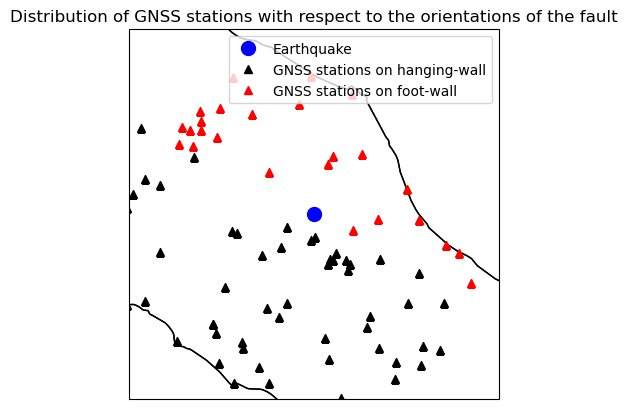

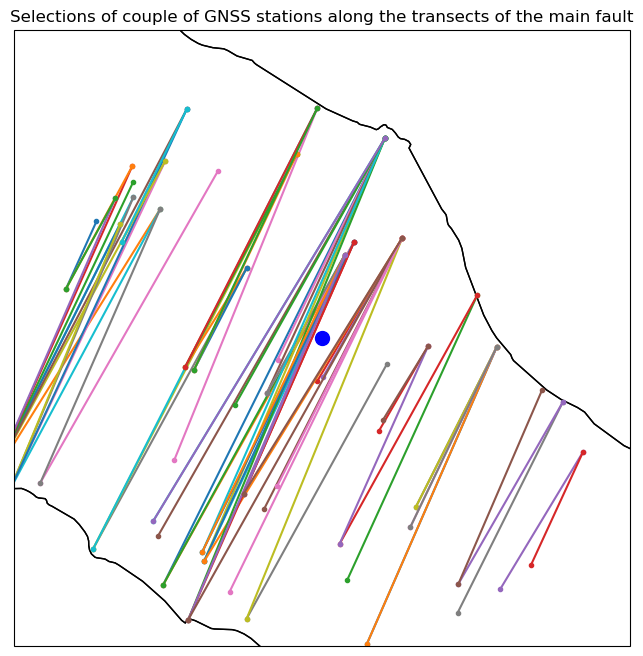

C:\Users\dedal\AppData\Local\Temp\ipykernel_13980\3524688390.py:229: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]


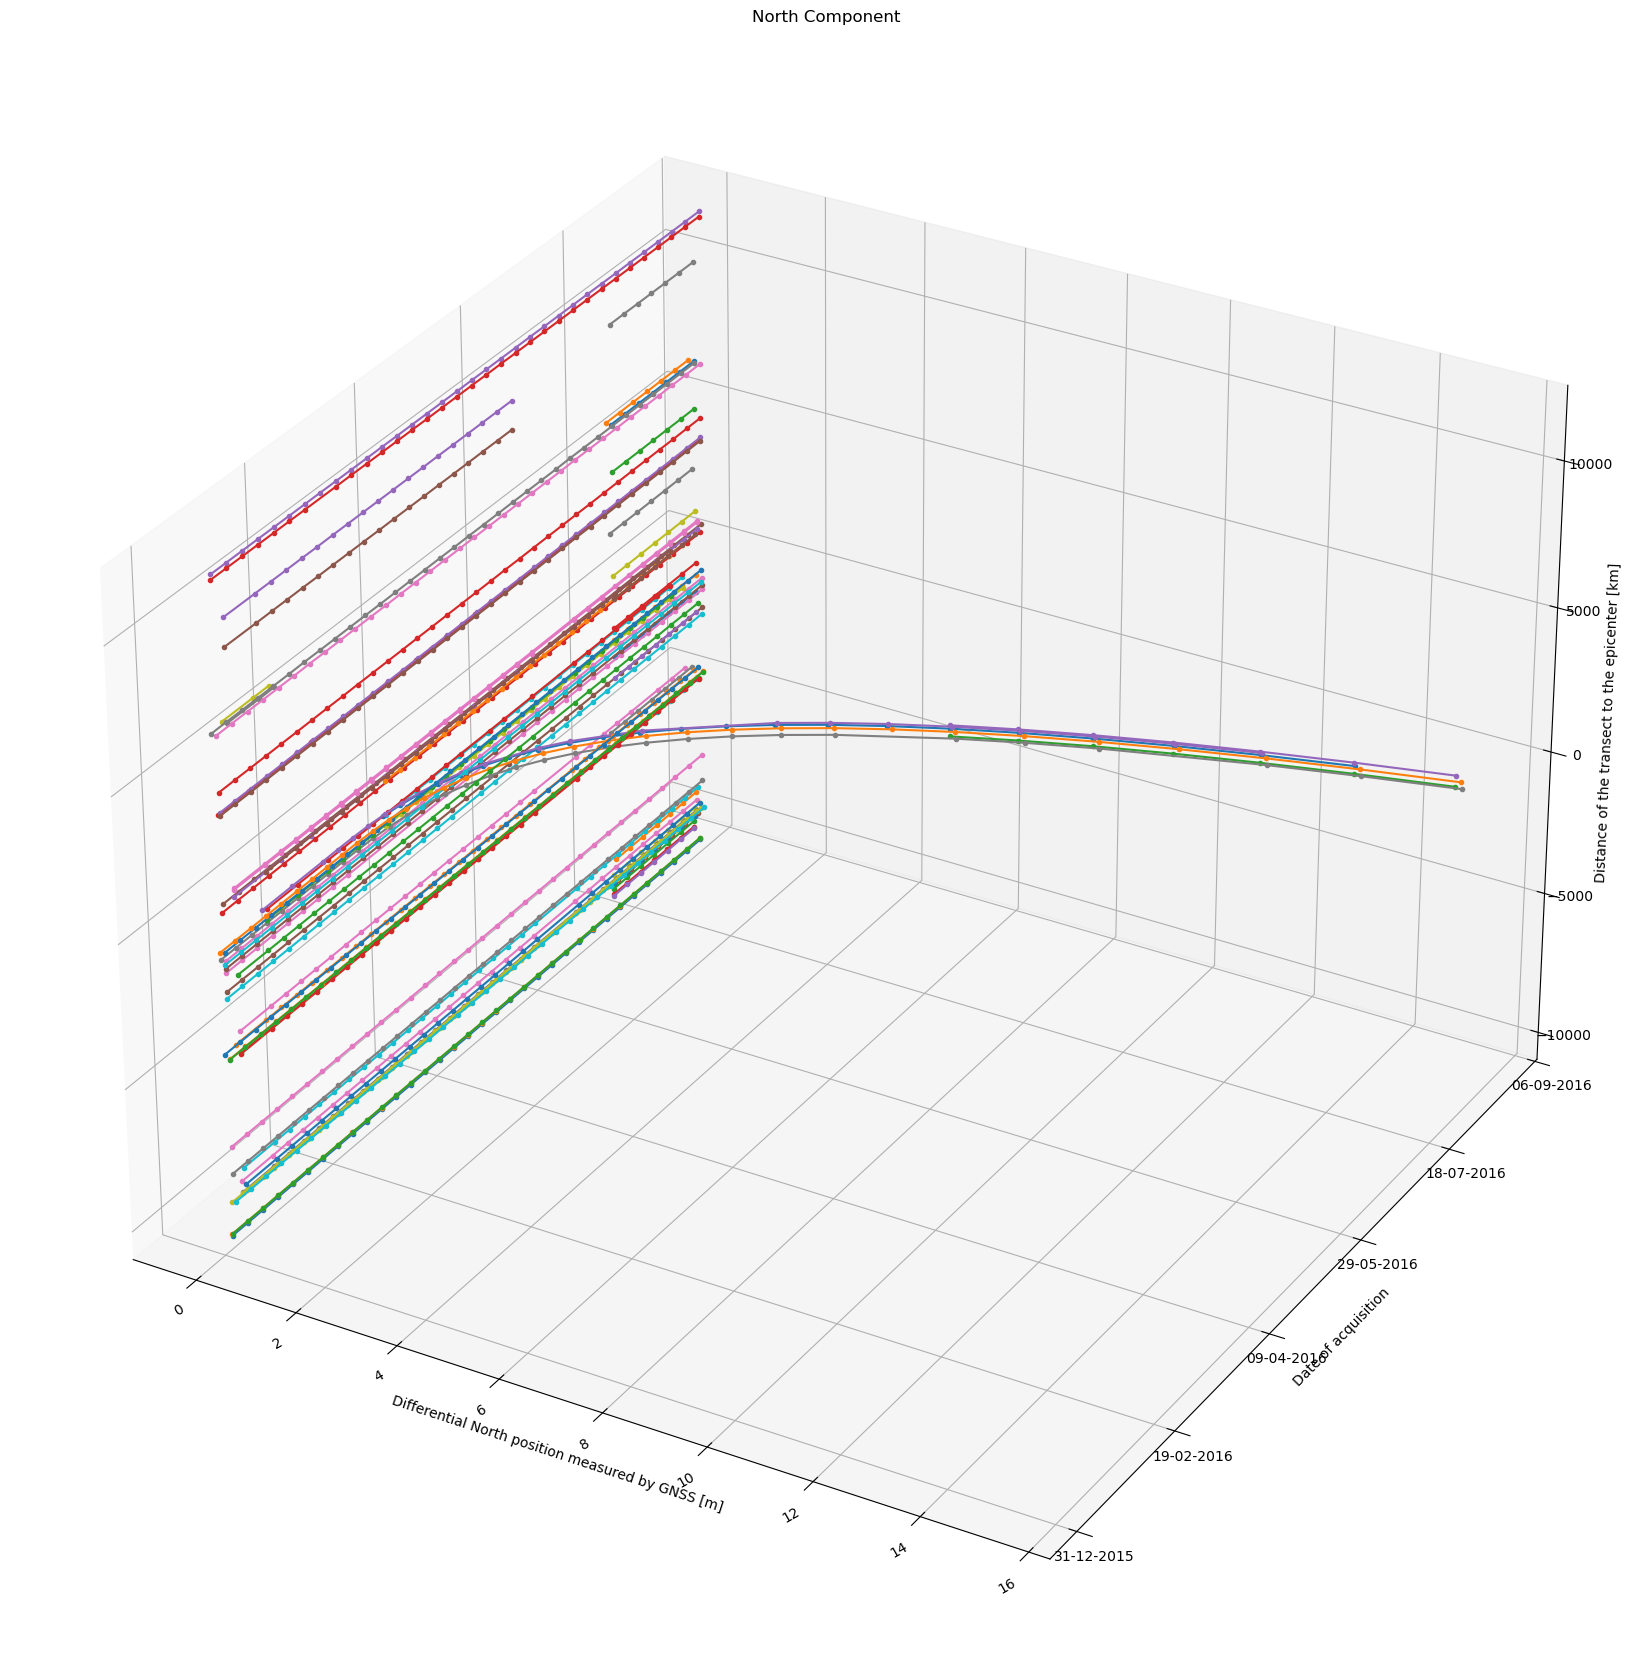

C:\Users\dedal\AppData\Local\Temp\ipykernel_13980\3524688390.py:256: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]


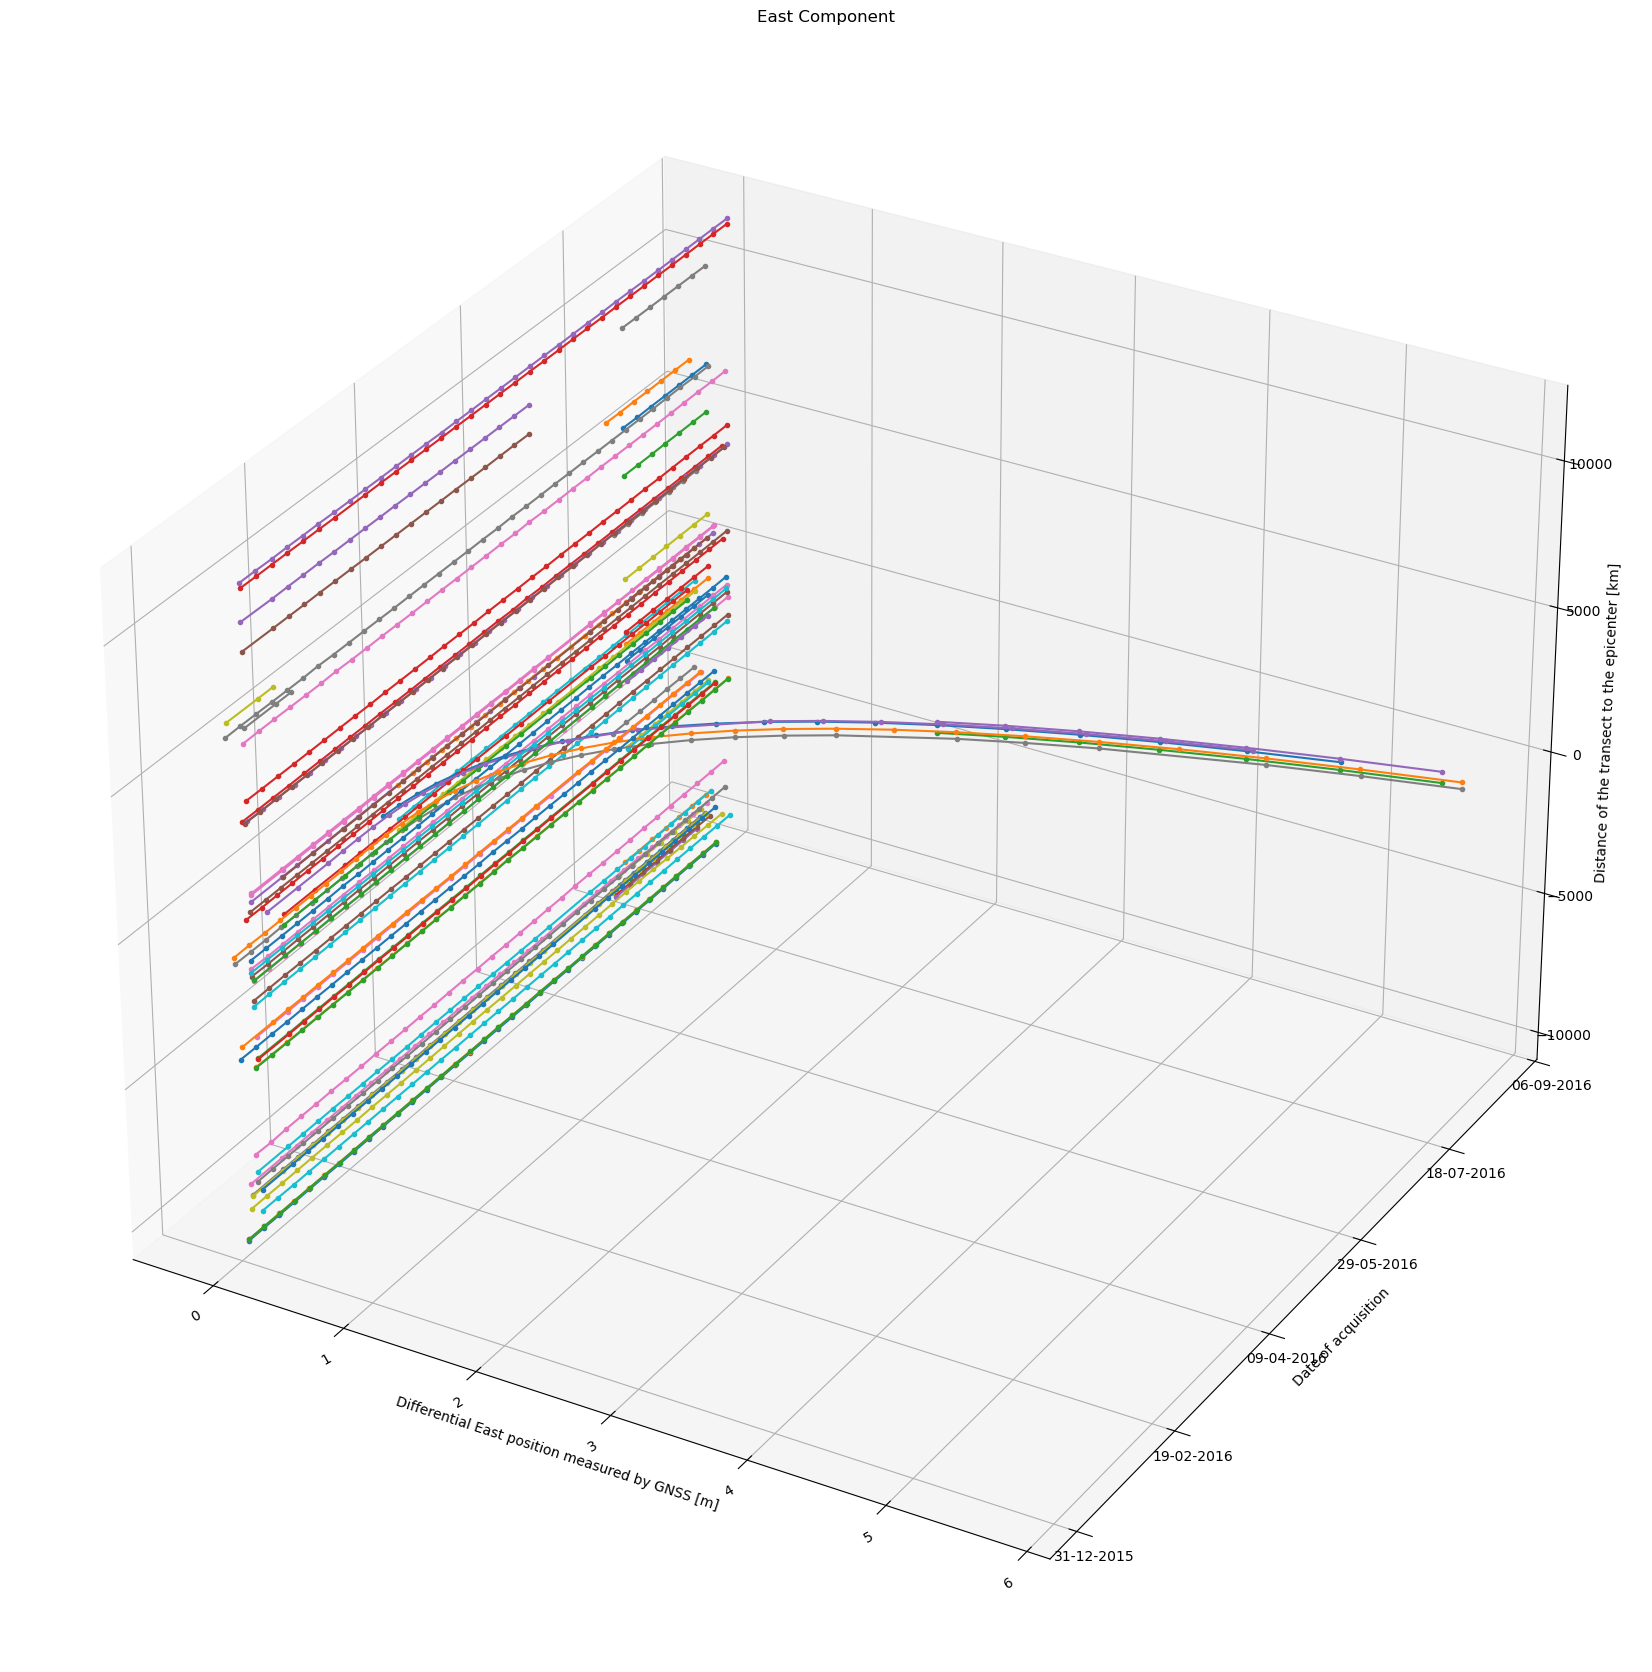

C:\Users\dedal\AppData\Local\Temp\ipykernel_13980\3524688390.py:282: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]


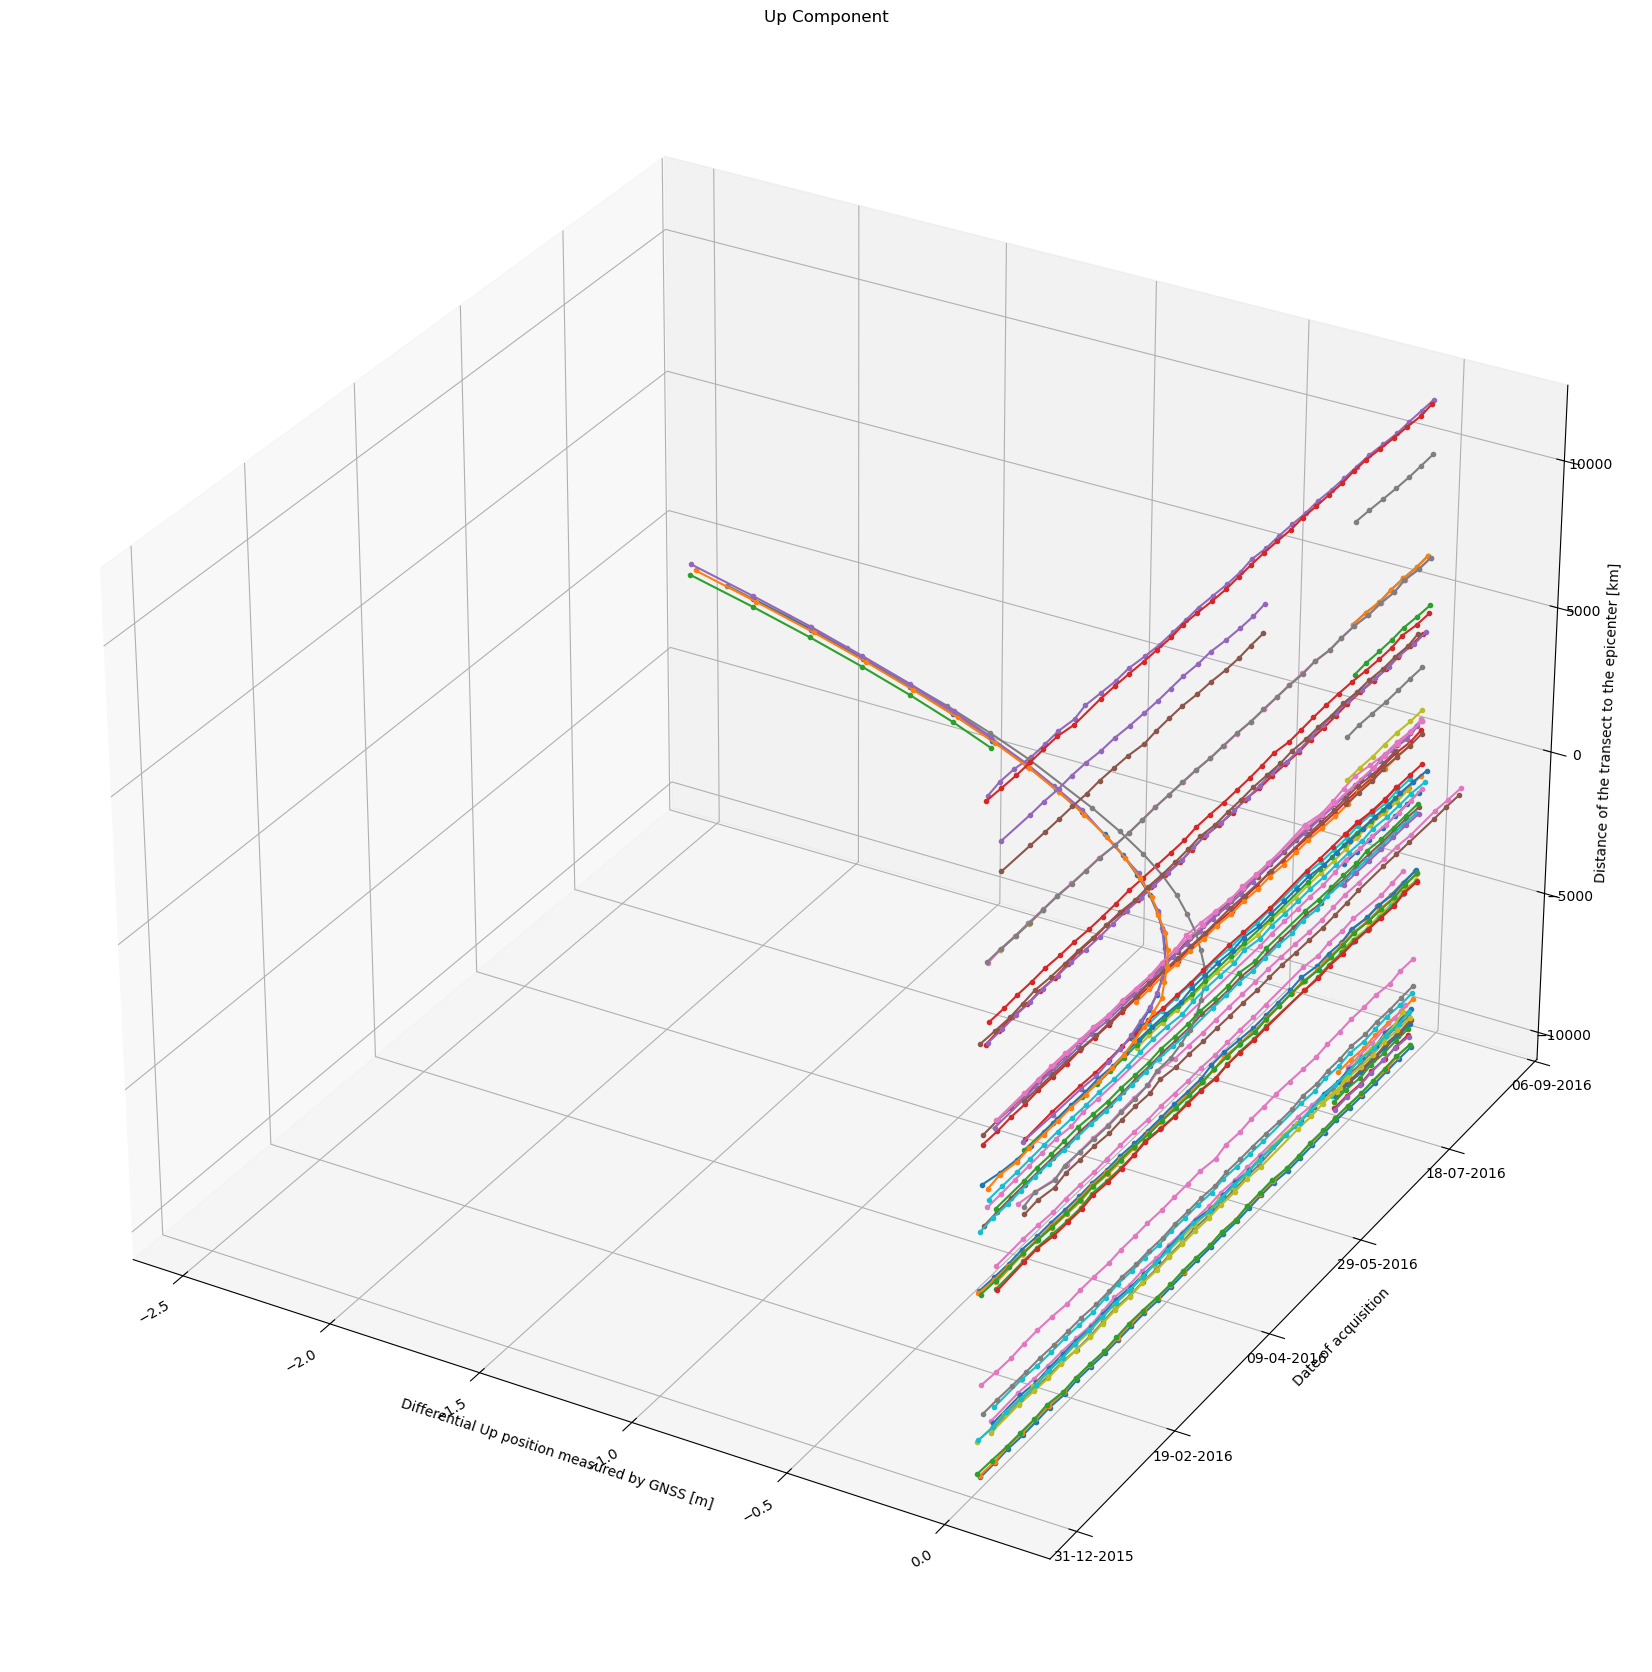

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Parameters ---
# Calculus of the straight angle of fault strike (same direction opposite verse)
complementary_strike_angle = Fault_strike - 180
# Calculus of the perpendicular direction to the one of the fault (transect direction)
perpendicular_angle = Fault_strike - 90

# --- Select GNSS stations on footwall and hanging-wall ---
mask_footwall = ((angle_to_EQ > complementary_strike_angle) & (angle_to_EQ < Fault_strike) &
                 (distance_GNSS_station_EQ <= Maximum_distance))
mask_hanging = ((angle_to_EQ < complementary_strike_angle) | (angle_to_EQ > Fault_strike)) & \
               (distance_GNSS_station_EQ <= Maximum_distance)

GNSS_stations_on_footwall = [data_from_GNSS[i] for i in range(len(data_from_GNSS)) if mask_footwall[i]]
GNSS_stations_on_hanging = [data_from_GNSS[i] for i in range(len(data_from_GNSS)) if mask_hanging[i]]

# Extract coordinates
GNSS_stations_on_hanging_coordinates = np.array([station['coordinates'] for station in GNSS_stations_on_hanging])
GNSS_stations_on_footwall_coordinates = np.array([station['coordinates'] for station in GNSS_stations_on_footwall])

# --- First Map Plot ---
plt.figure()
# ---------------------------------------------------------------------------

ax = plt.axes(projection=ccrs.PlateCarree())

# Add global coastlines with higher resolution (10 m)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))

# Retrieve coastline coordinates
coastline = cfeature.COASTLINE.with_scale('10m')

# Add high‑resolution coastlines (10 m)
ax.coastlines(resolution='10m', linewidth=1)


# Epicenter plot
ax.plot(epilon, epilat, 'ob', markersize=10, markerfacecolor='b', label='Earthquake',transform=ccrs.PlateCarree())


# Extract coordinates properly as a 2D numpy array
GNSS_stations_on_hanging_coordinates = np.array([station['coordinates'] for station in GNSS_stations_on_hanging]).reshape(-1, 2)
GNSS_stations_on_footwall_coordinates = np.array([station['coordinates'] for station in GNSS_stations_on_footwall]).reshape(-1, 2)

# Plot only if data exists
if GNSS_stations_on_hanging_coordinates.size > 0:
    ax.plot(GNSS_stations_on_hanging_coordinates[:, 0], GNSS_stations_on_hanging_coordinates[:, 1], '^k', markerfacecolor='k',transform=ccrs.PlateCarree())

if GNSS_stations_on_footwall_coordinates.size > 0:
    ax.plot(GNSS_stations_on_footwall_coordinates[:, 0], GNSS_stations_on_footwall_coordinates[:, 1], '^r', markerfacecolor='r', transform=ccrs.PlateCarree())
    
ax.axis([
    epilon - Maximum_distance / 111, epilon + Maximum_distance / 111,
    epilat - Maximum_distance / 111, epilat + Maximum_distance / 111
])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Earthquake', 'GNSS stations on hanging-wall', 'GNSS stations on foot-wall'])
plt.title('Distribution of GNSS stations with respect to the orientations of the fault')
plt.grid(True)
plt.show()

from scipy.interpolate import PchipInterpolator
from pyproj import Geod
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime

# Use Geod to compute geodetic distance
geod = Geod(ellps="WGS84")

results_from_perpendicular_stations = []

# Initialise the map
fig_transects = plt.figure(figsize=(10, 8))
ax_transects = plt.axes(projection=ccrs.PlateCarree())
ax_transects.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax_transects.coastlines(resolution='10m', linewidth=1)
ax_transects.set_extent([
    epilon - Maximum_distance / 111, epilon + Maximum_distance / 111,
    epilat - Maximum_distance / 111, epilat + Maximum_distance / 111
], crs=ccrs.PlateCarree())
ax_transects.set_title('Selections of couple of GNSS stations along the transects of the main fault')

# Geod for geodetic distances
geod = Geod(ellps="WGS84")

# Lista dei risultati
results_from_perpendicular_stations = []

# Function to compute angular distance periodically
def angular_distance(a, b):
    return np.abs((a - b + 180) % 360 - 180)

# Utility function: robust timestamp conversion
def safe_ts(ts):
    if isinstance(ts, str) and '-' in ts:
        return datetime.fromisoformat(ts).timestamp()
    else:
        return float(ts)

# Section coordinates
hanging_coords = np.array([s['coordinates'] for s in GNSS_stations_on_hanging])
footwall_coords = np.array([s['coordinates'] for s in GNSS_stations_on_footwall])

# Main loop
for i, hanging_station in enumerate(GNSS_stations_on_hanging):
    coord_hanging = hanging_station["coordinates"]
    data_from_station_1 = hanging_station["data"]

    # Compute angles to all footwall stations
    angle_to_station = np.degrees(np.arctan2(
        footwall_coords[:, 1] - coord_hanging[1],
        footwall_coords[:, 0] - coord_hanging[0]
    ))
    

    # Filter perpendicular stations
    mask = (angular_distance(angle_to_station, Fault_strike - 90) <= angular_tolerance) | \
            (angular_distance(angle_to_station, Fault_strike - 270) <= angular_tolerance)
    index_good_stations = np.where(mask)[0]
    
    #print(index_good_stations)
    #print(angle_to_station)
    #print(footwall_coords[:, 1],footwall_coords[:, 0])
    #print(coord_hanging[1],coord_hanging[0])
    


    if len(index_good_stations) == 0:
        continue

# Reference timestamp
    t_ref = np.array([safe_ts(ts) for ts in data_from_station_1[:, 0]])

    if len(t_ref) < 2:
        continue
    #print(index_good_stations)
# For every compliant station
    for k in index_good_stations:
        footwall_station = GNSS_stations_on_footwall[k]
        coord_footwall = footwall_station["coordinates"]
        data_from_station_2 = footwall_station["data"]

        t_other = np.array([safe_ts(ts) for ts in data_from_station_2[:, 0]])
        if len(t_other) < 2:
            continue

        # Interpolate pchip
        data_interp = np.zeros_like(data_from_station_1, dtype=float)
        data_interp[:, 0] = t_ref
        for col in range(1, 4):
            try:
                f = PchipInterpolator(t_other, data_from_station_2[:, col].astype(float))
                data_interp[:, col] = f(t_ref)
            except Exception as e:
                print(f"Errore interpolazione (stazione {i}-{k}): {e}")
                break

        # GNSS differences
        differences_GNSS = data_from_station_1[:, 1:4].astype(float) - data_interp[:, 1:4]

        # Geodetic Distance (triangle)
        _, _, d1 = geod.inv(coord_footwall[0], coord_footwall[1], coord_hanging[0], coord_hanging[1])
        _, _, d2 = geod.inv(epilon, epilat, coord_hanging[0], coord_hanging[1])
        _, _, d3 = geod.inv(coord_footwall[0], coord_footwall[1], epilon, epilat)
        d1 /= 1000
        d2 /= 1000
        d3 /= 1000

        s = 0.5 * (d1 + d2 + d3)
        area = np.sqrt(s * (s - d1) * (s - d2) * (s - d3))
        height = 2 * area / d1
        distance_from_EQ = height * 111  # km

        # Sign of the distance (positive/negative)
        angle_of_st2_to_EQ = np.degrees(np.arctan2(
            coord_footwall[1] - epilat,
            coord_footwall[0] - epilon
        ))
        if angle_of_st2_to_EQ > perpendicular_angle:
            distance_from_EQ *= -1

        # Plot line between the stations
        ax_transects.plot(
            [coord_footwall[0], coord_hanging[0]],
            [coord_footwall[1], coord_hanging[1]],
            '.-', transform=ccrs.PlateCarree()
        )
        
        # Save the result
        results_from_perpendicular_stations.append({
            "distance": distance_from_EQ,
            "differences_GNSS": differences_GNSS,
            "time_differences_GNSS": t_ref,
            "distance_st1_st2": d1
        })
        
# Epicenter plot
ax_transects.plot(epilon, epilat, 'ob', markersize=10, markerfacecolor='b', label='Earthquake',transform=ccrs.PlateCarree())

# Final visualization
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# --- First Plot: North Component ---
fig = plt.figure(figsize=(48, 24))
ax = fig.add_subplot(111, projection='3d')

for res in results_from_perpendicular_stations:
    distance_GNSS = res['distance']
    data_station = res['differences_GNSS']
    time_data_station = res['time_differences_GNSS']

# Convert timestamp to datetime
    time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]

# Plot: X = differential, Y = time, Z = distance
    ax.plot(
        data_station[:, 0],                      # X = Differenziale North
        mdates.date2num(time_data_station_dt),    # Y = Date of acquisition
        distance_GNSS * np.ones_like(data_station[:, 0]),  # Z = Fixed distance
        '.-'
    )

ax.set_xlabel('Differential North position measured by GNSS [m]')
ax.set_ylabel('Date of acquisition')
ax.set_zlabel('Distance of the transect to the epicenter [km]')
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()
plt.title('North Component')
plt.show()

# --- Second Plot: East component ---
fig = plt.figure(figsize=(48, 24))
ax = fig.add_subplot(111, projection='3d')

for res in results_from_perpendicular_stations:
    distance_GNSS = res['distance']
    data_station = res['differences_GNSS']
    time_data_station = res['time_differences_GNSS']

    time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]

    ax.plot(
        data_station[:, 1],                      # X = Differenziale East
        mdates.date2num(time_data_station_dt),    # Y = Date of acquisition
        distance_GNSS * np.ones_like(data_station[:, 1]),  # Z = Fixed distance
        '.-'
    )
    
ax.set_xlabel('Differential East position measured by GNSS [m]')
ax.set_ylabel('Date of acquisition')
ax.set_zlabel('Distance of the transect to the epicenter [km]')
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()
plt.title('East Component')
plt.show()

# --- Third Plot: Up Component ---
fig = plt.figure(figsize=(48, 24))
ax = fig.add_subplot(111, projection='3d')

for res in results_from_perpendicular_stations:
    distance_GNSS = res['distance']
    data_station = res['differences_GNSS']
    time_data_station = res['time_differences_GNSS']

    time_data_station_dt = [datetime.utcfromtimestamp(ts) for ts in time_data_station]

    ax.plot(
        data_station[:, 2],                      # X = Differenziale Up
        mdates.date2num(time_data_station_dt),    # Y = Date of acquisition
        distance_GNSS * np.ones_like(data_station[:, 2]),  # Z = fixed distance
        '.-'
    )

ax.set_xlabel('Differential Up position measured by GNSS [m]')
ax.set_ylabel('Date of acquisition')
ax.set_zlabel('Distance of the transect to the epicenter [km]')
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()
plt.title('Up Component')
plt.show()

## Creations of maps of GNSS rate of displacements
The following code calculates the rate of GNSS displacement in the form of maps.  
It first homogenises the data in a three-dimensional vector with time and space positions as coordinates. It fills the missing gaps whenever possible and after it calculates the difference of GNSS positions for each component divided by the time span between the two measurements, which is generally one week.  
It then plots the interpolated maps for the North, East Up component for each time step (generally one week if data are available).

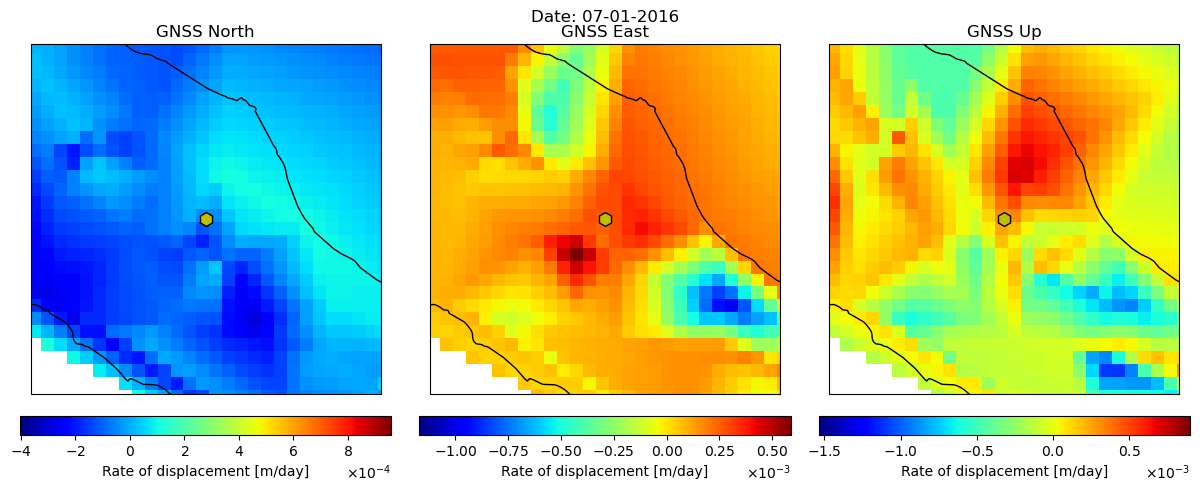

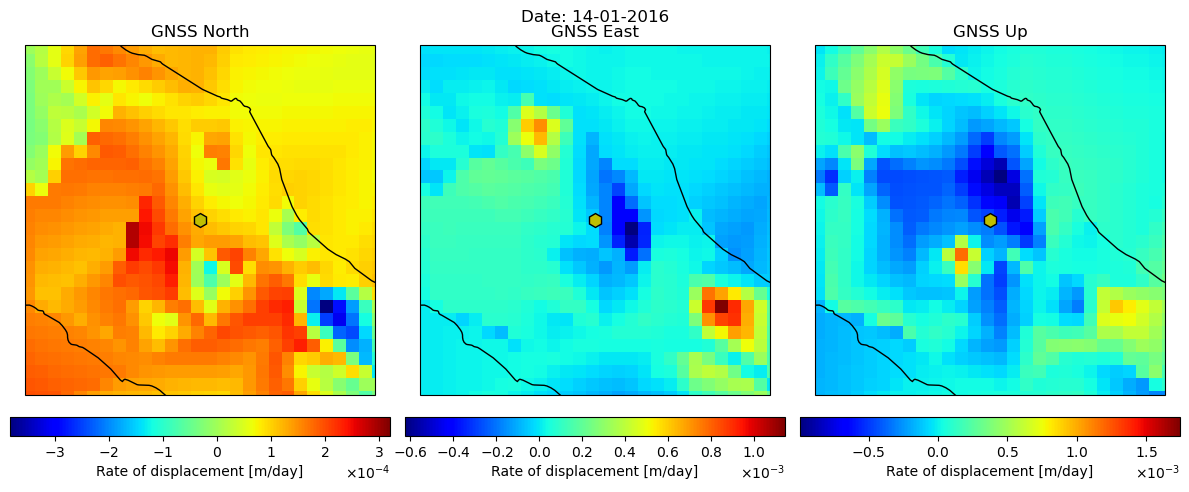

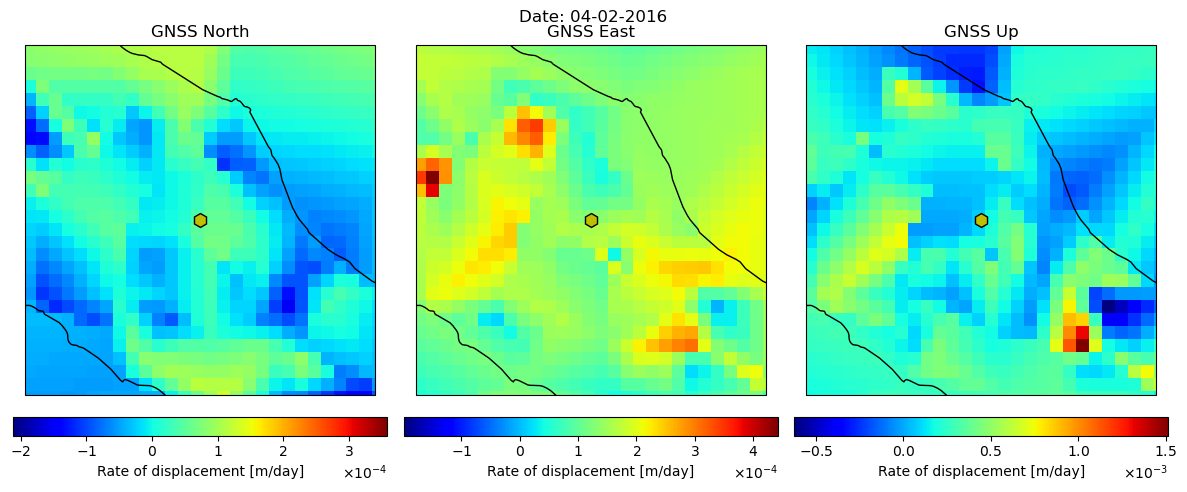

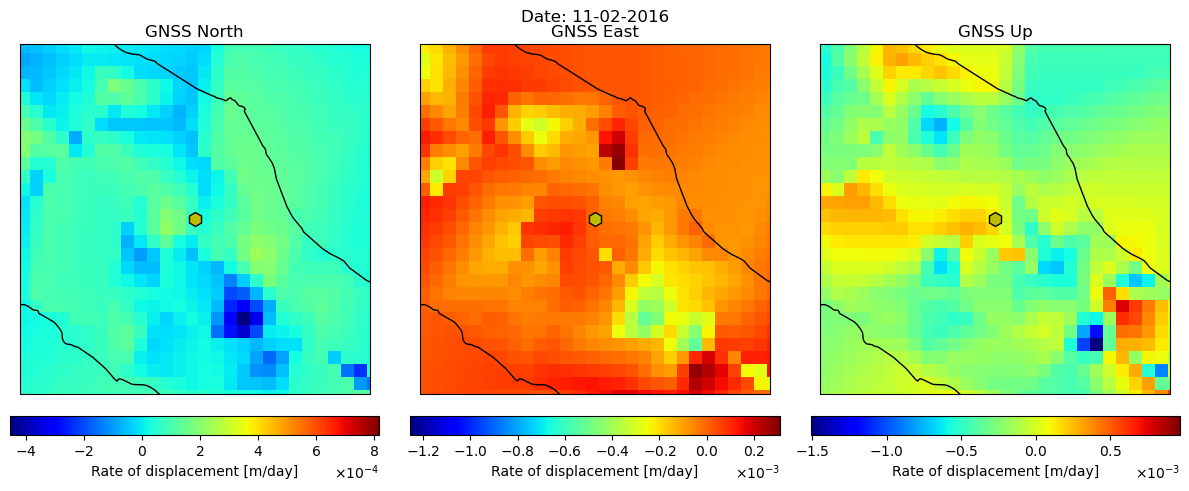

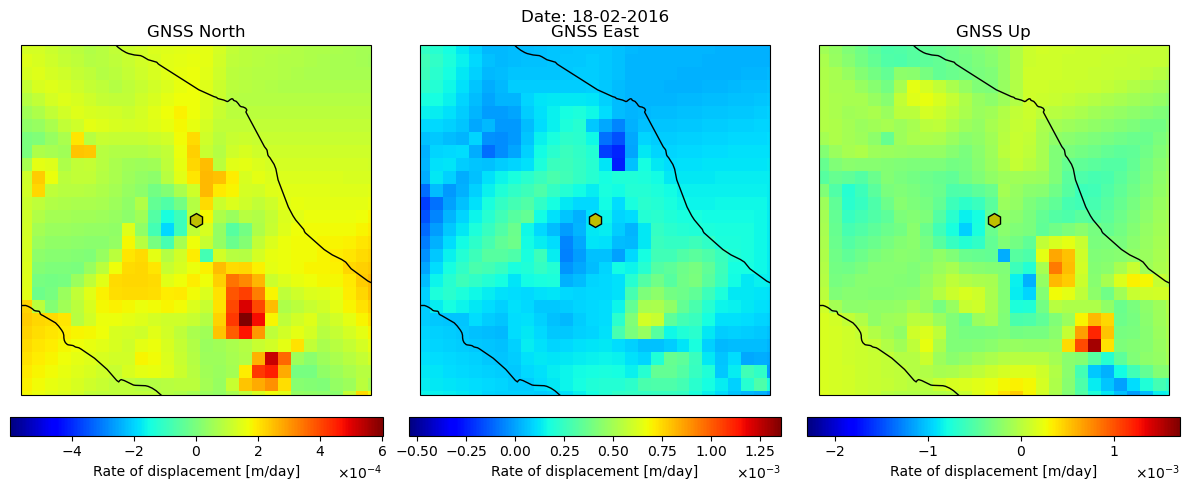

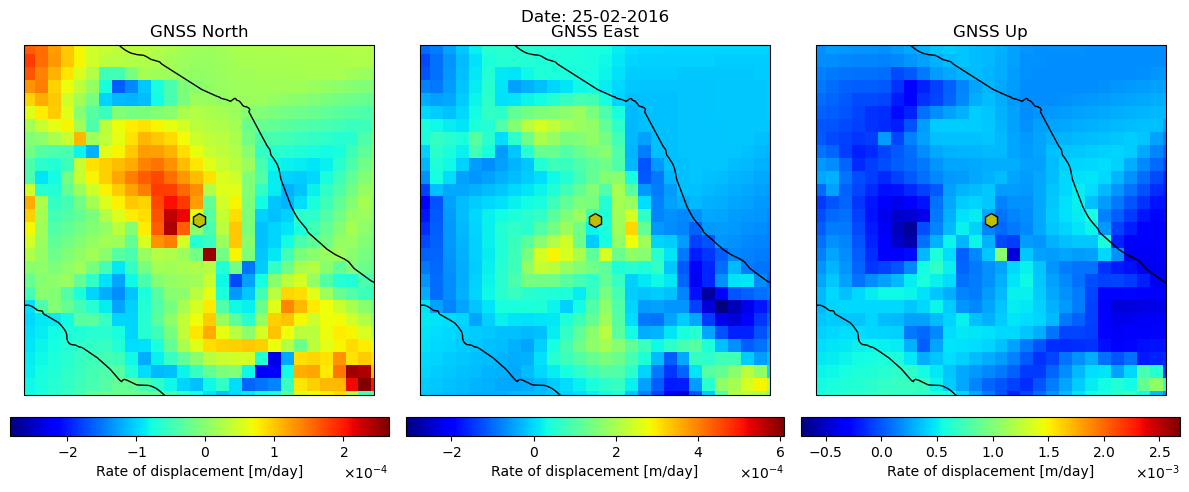

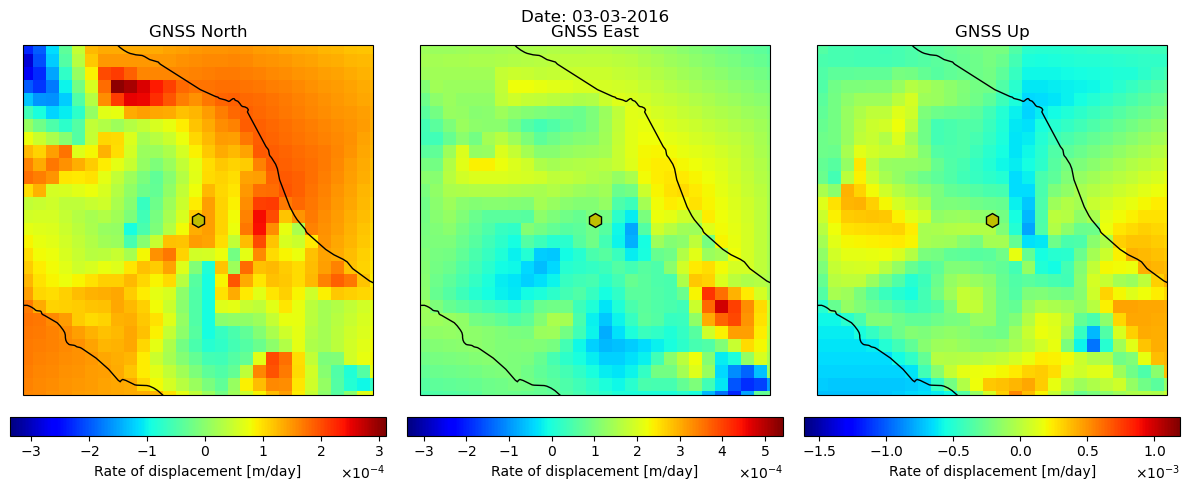

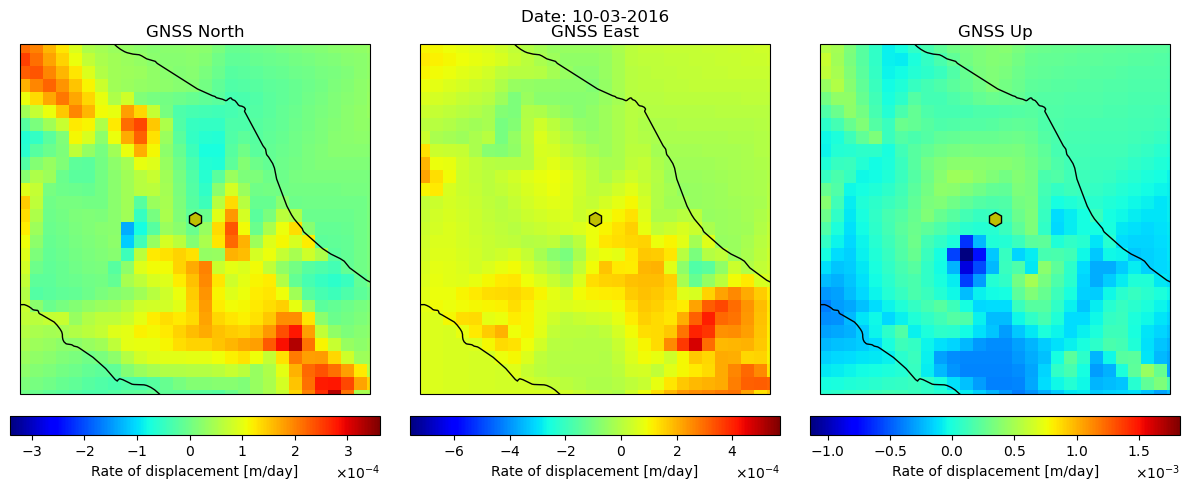

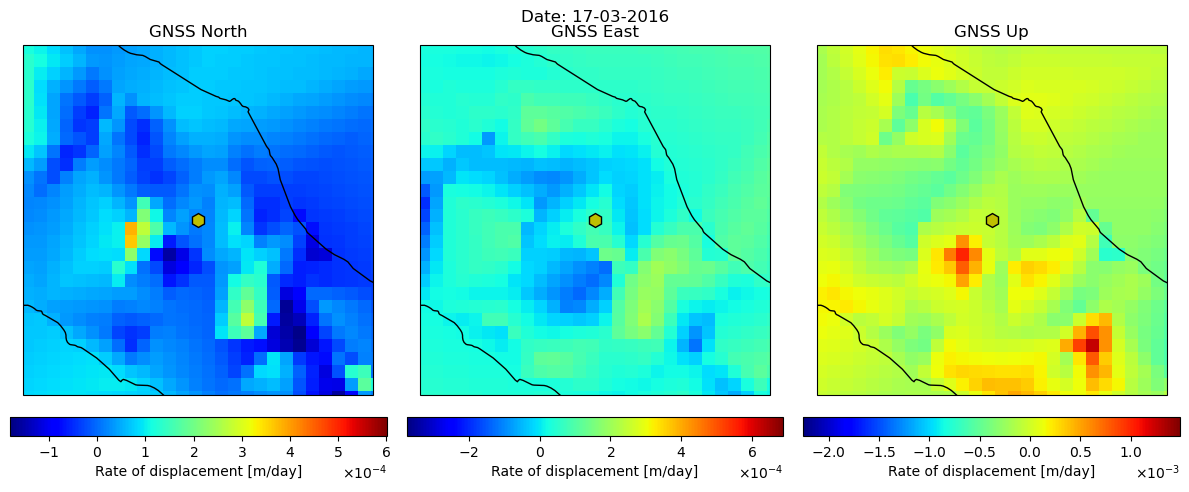

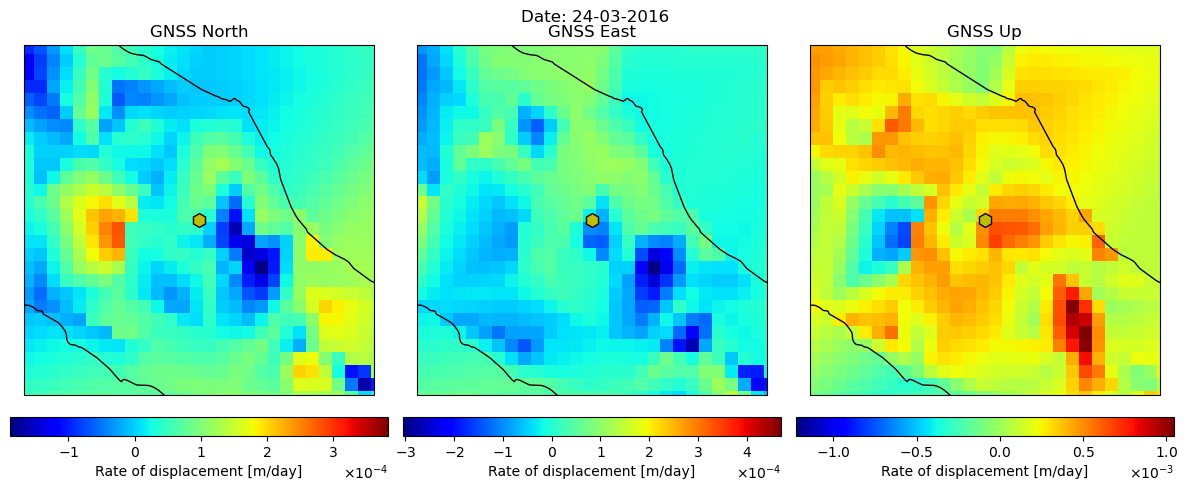

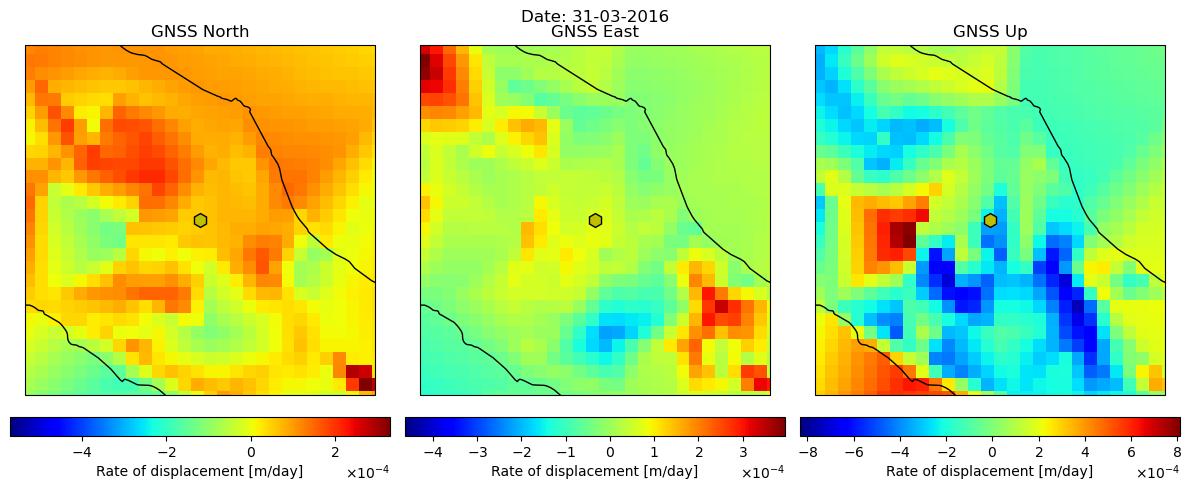

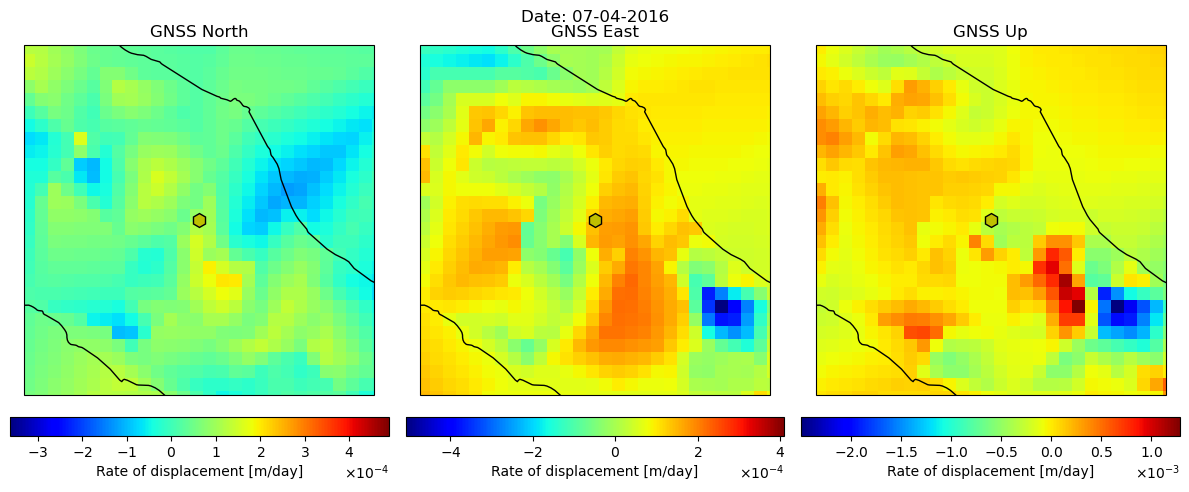

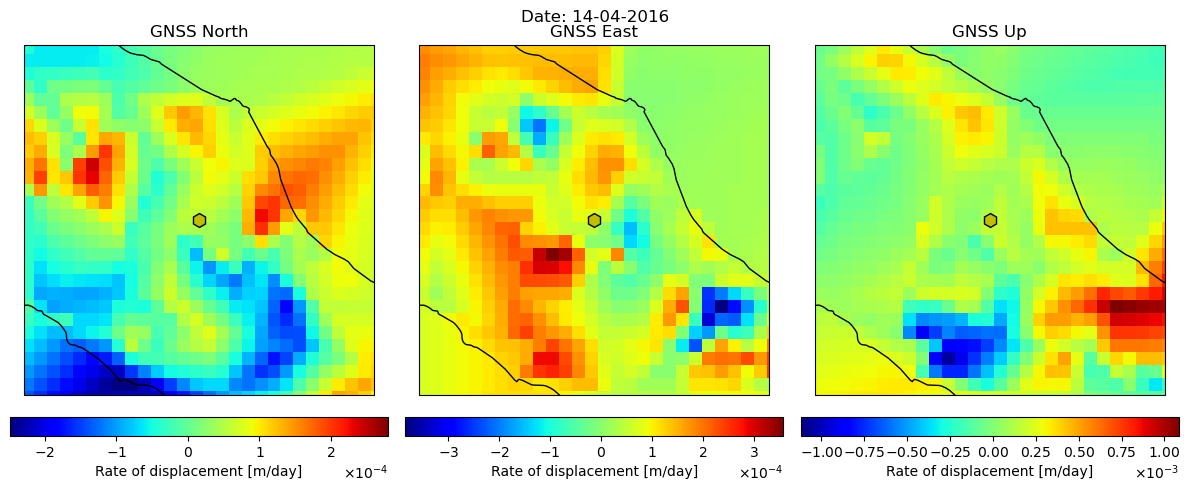

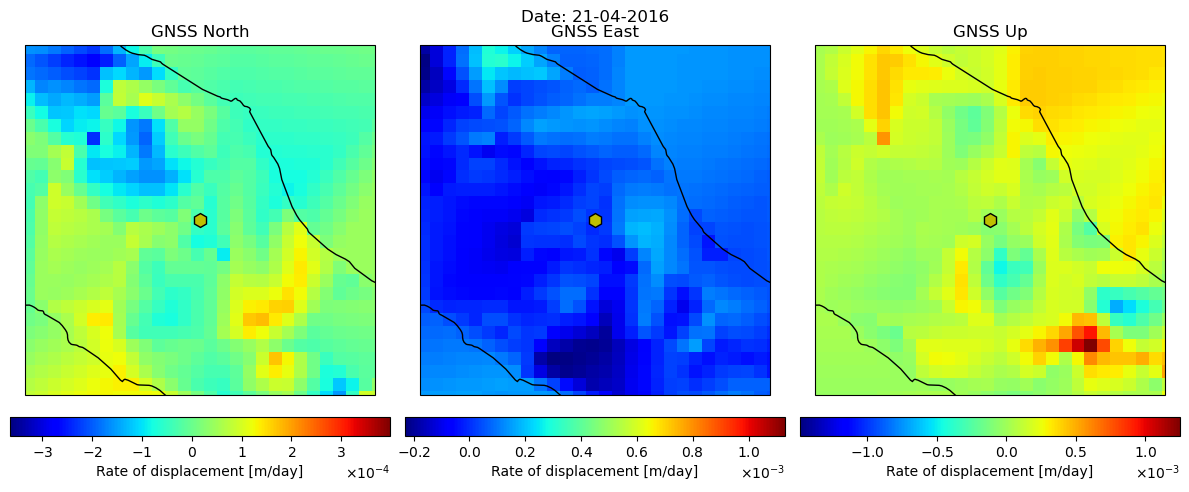

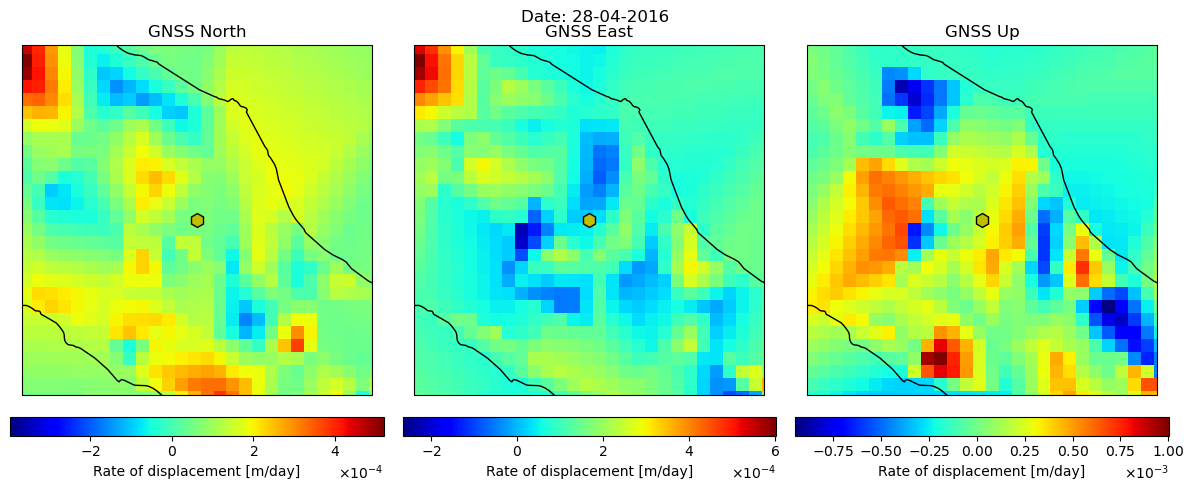

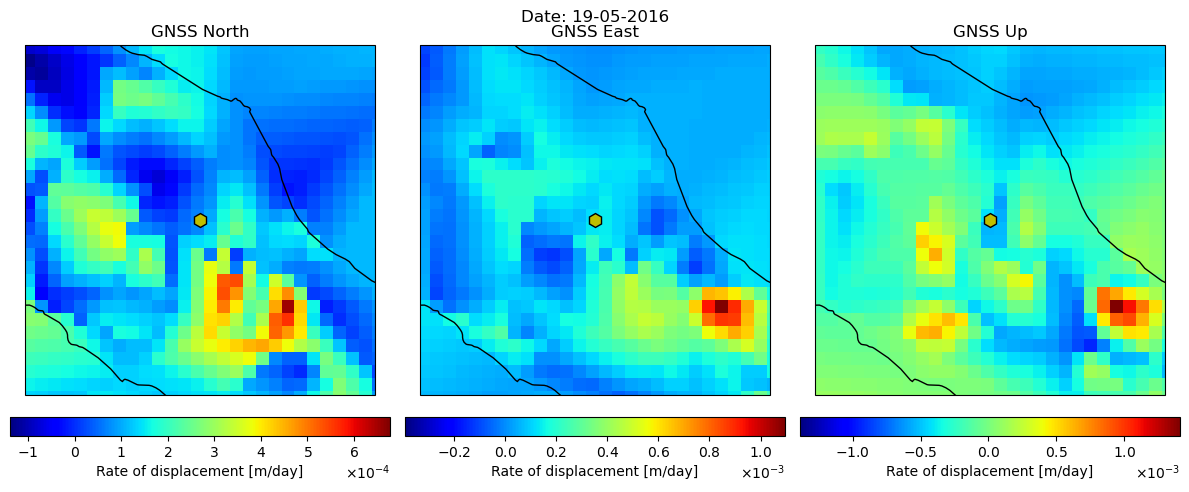

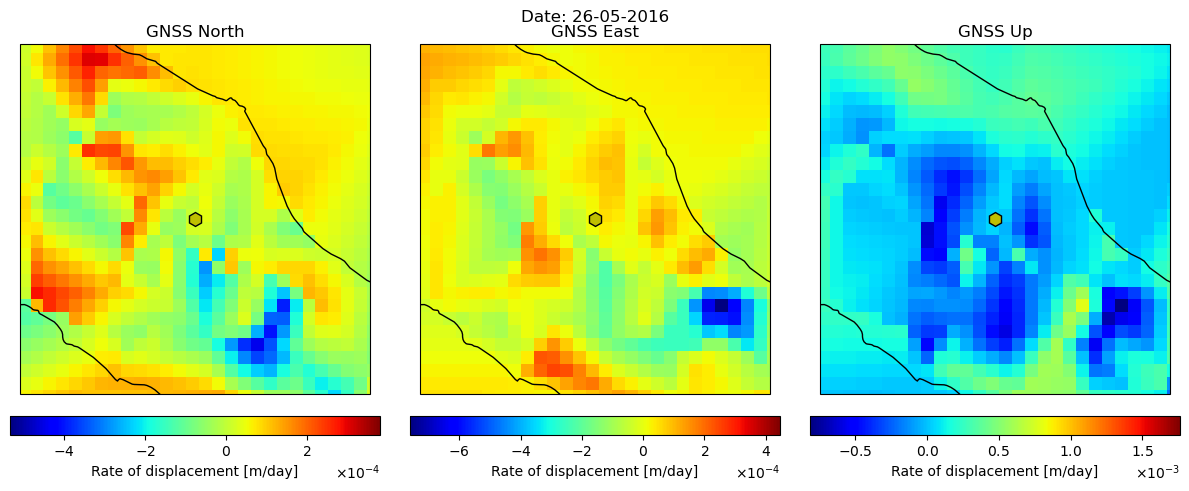

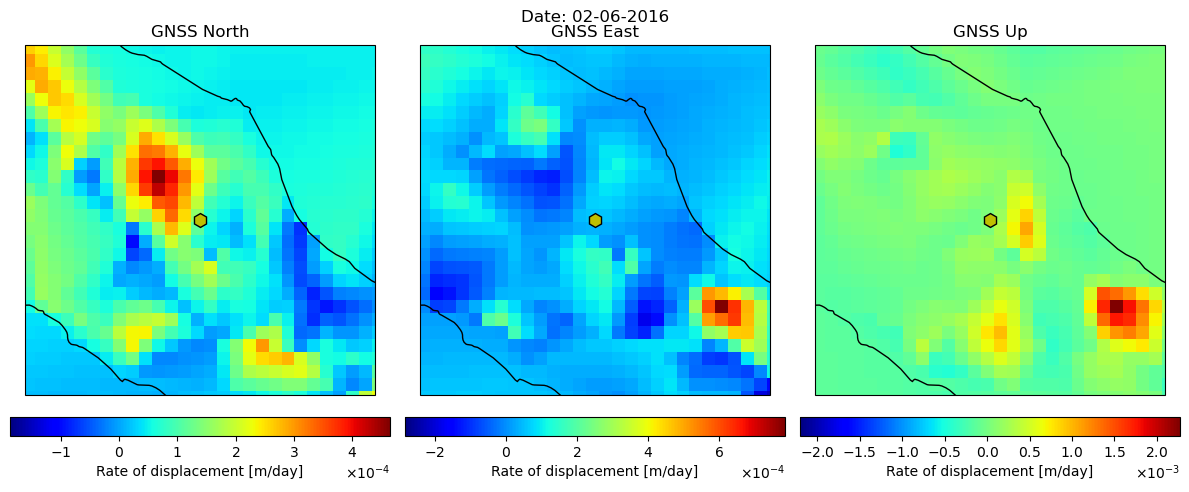

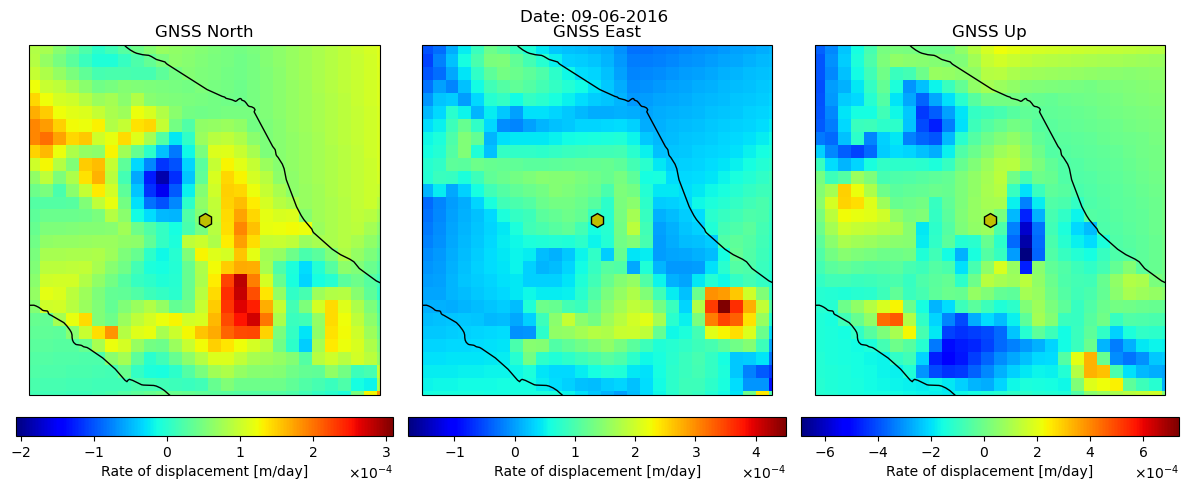

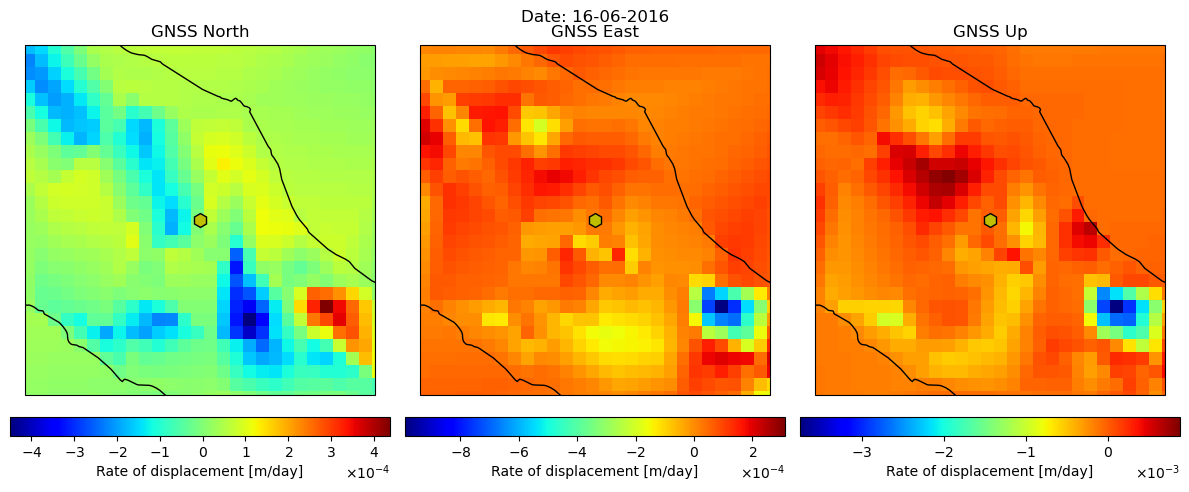

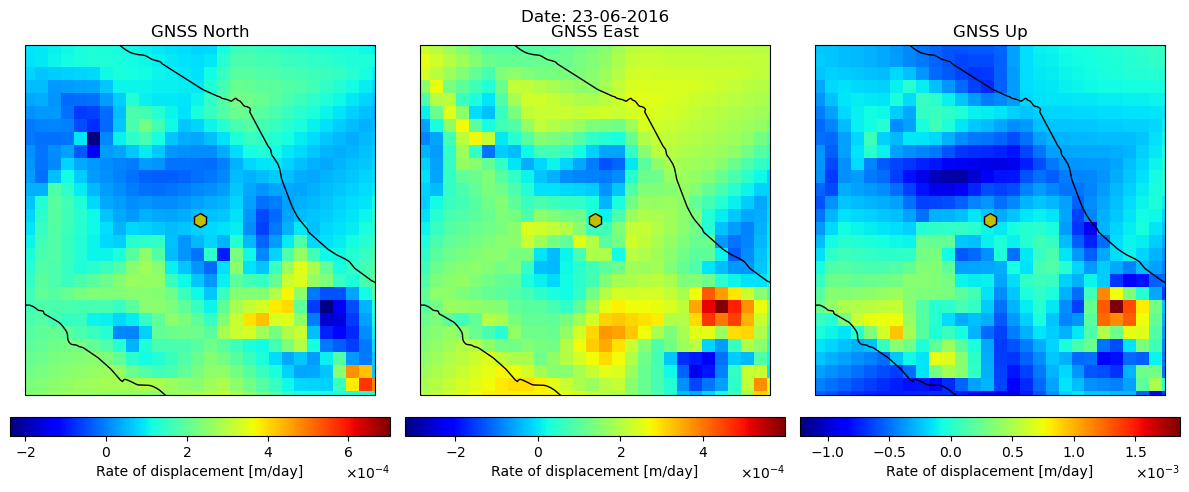

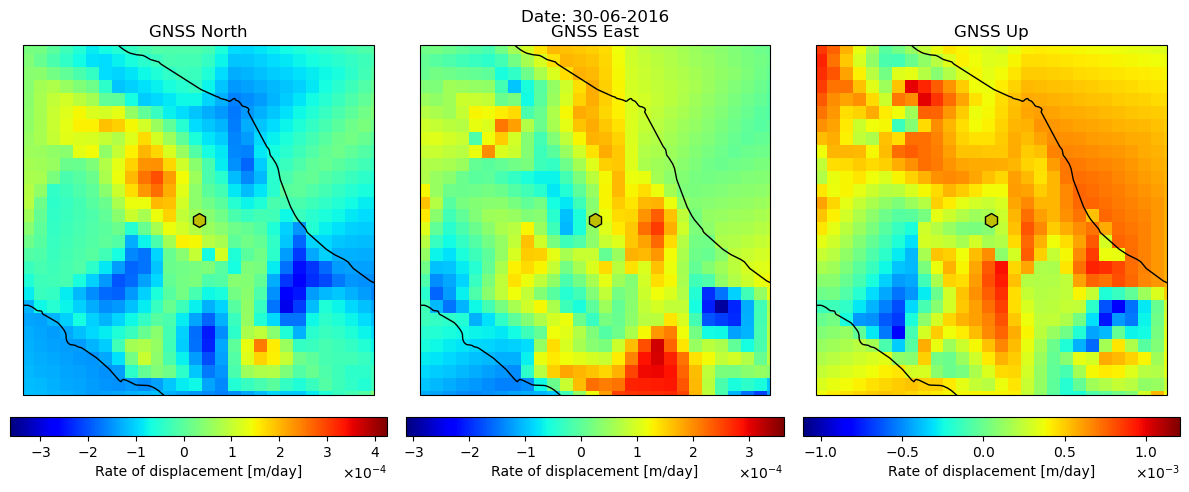

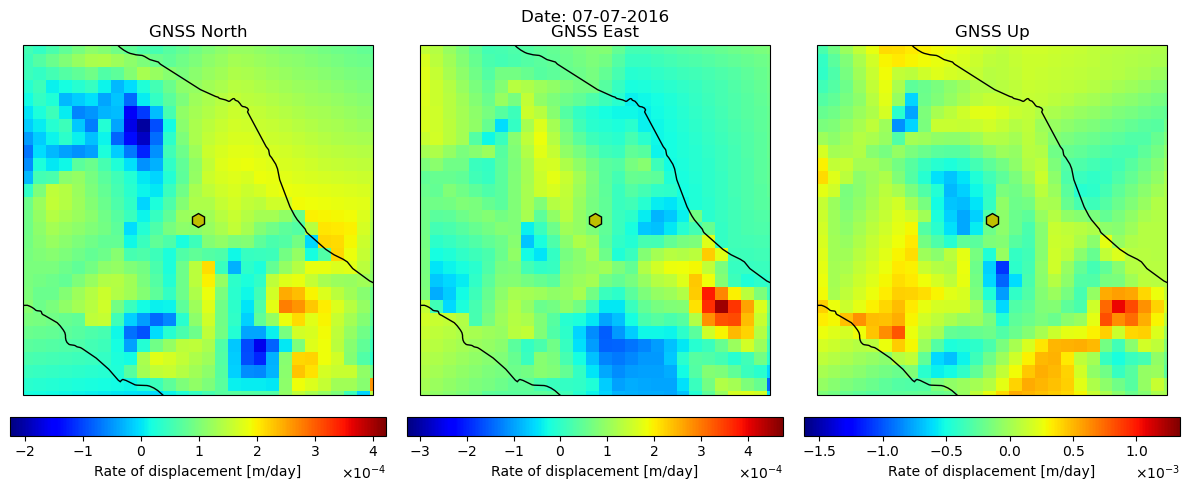

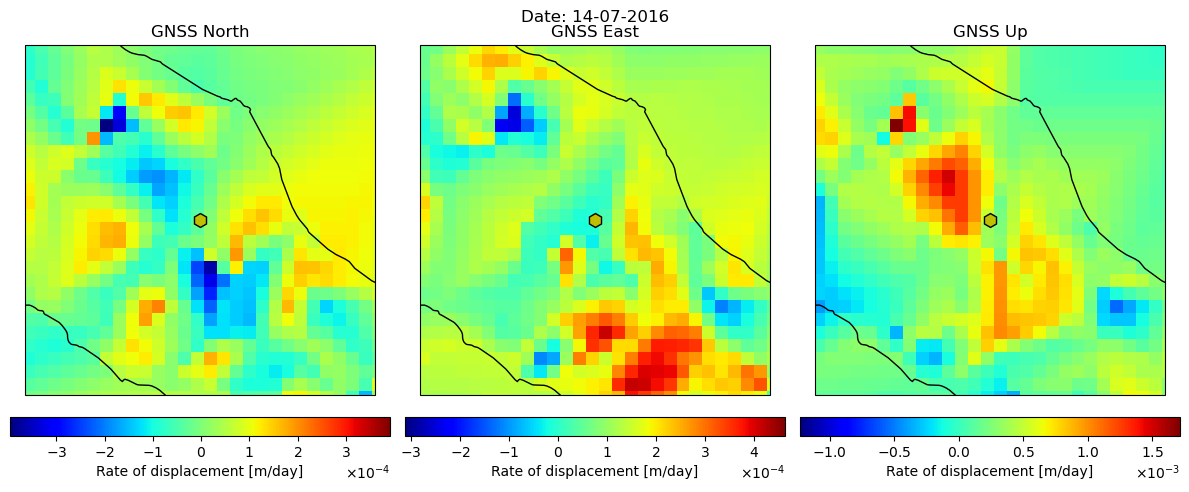

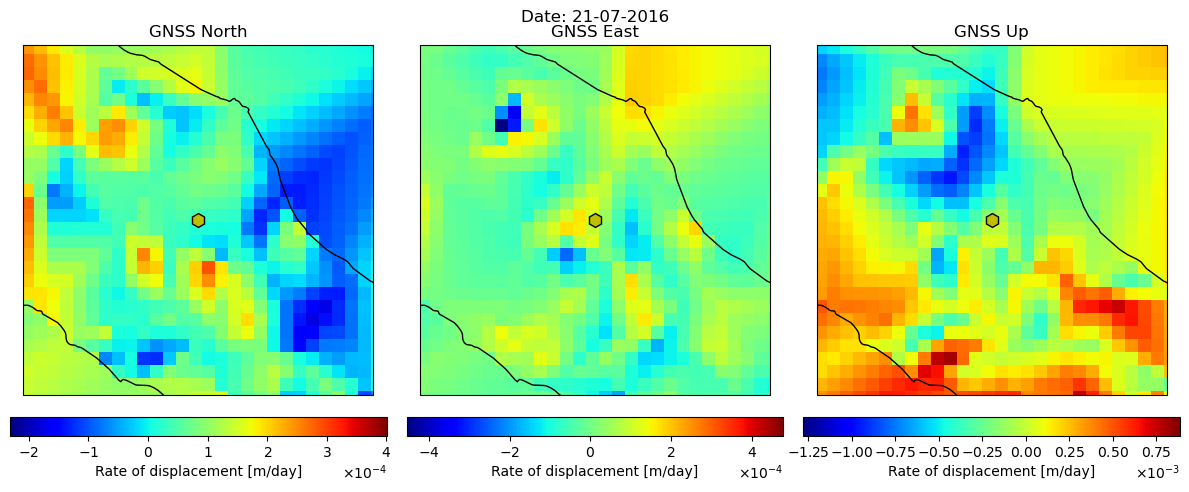

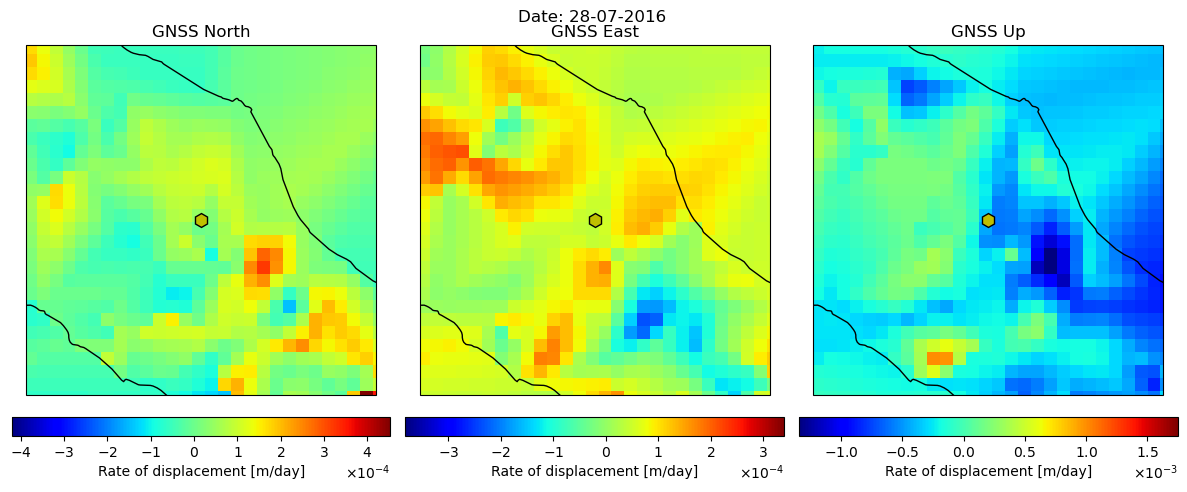

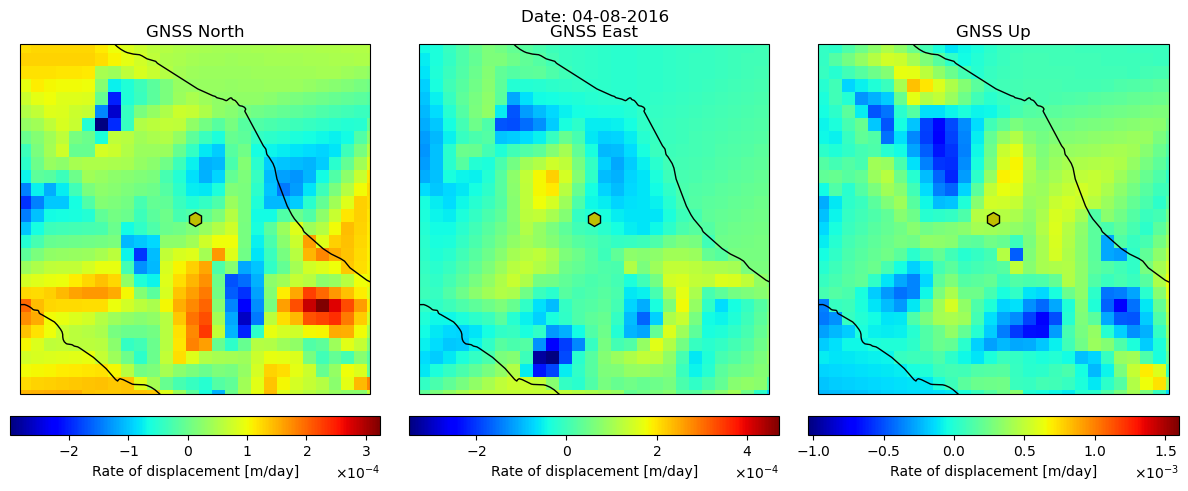

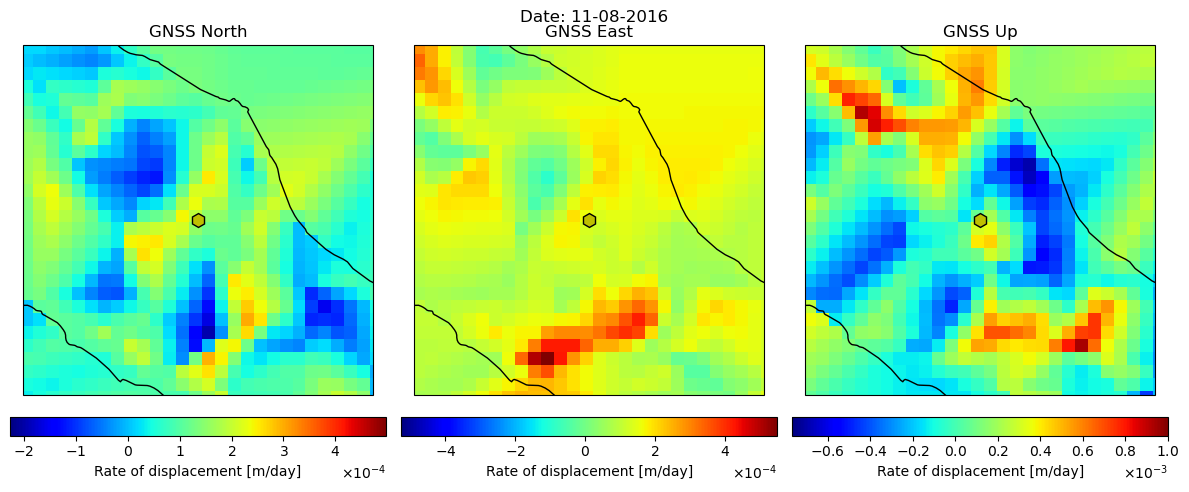

In [16]:
import numpy as np
import pandas as pd
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import ScalarFormatter


# ------------------------------------------------------------------
# 0) Utility: timestamp (strings/datetime) → UTC seconds
# ------------------------------------------------------------------
def _to_epoch_seconds(arr):
    """
    Converte un array 1-D in float64 = secondi dal 1-1-1970 00:00:00 UTC.
    """
    if np.issubdtype(arr.dtype, np.number):
        return arr.astype(float)          # già numerico
    return pd.to_datetime(arr, utc=True).astype("int64") / 1e9  # ns → s

# ------------------------------------------------------------------
# 1) Build GNSS_timestamp and N‑E‑U numeric array
# ------------------------------------------------------------------
N_stazioni = len(data_from_GNSS)

# Collect all timestamps and numeric data in temporary lists
all_timestamps = []
all_numeric    = []       # List of arrays (variable length) N×3 per station

for staz in data_from_GNSS:
    raw   = staz["data"]                      # string arrays
    ts    = _to_epoch_seconds(raw[:, 0])      # col 0 → seconds
    nums  = raw[:, 1:4].astype(float)         # col 1-3 → float
    all_timestamps.append(ts)
    all_numeric.append(nums)

# Global time vector ordered and unique
GNSS_timestamp = np.unique(np.concatenate(all_timestamps))

# 3‑D matrix (time × stations × 3) initialised with NaN
GNSS_all_data = np.full((len(GNSS_timestamp), N_stazioni, 3), np.nan, dtype=float)

# Fill the matrix using the same strategy
for i, (ts, nums) in enumerate(zip(all_timestamps, all_numeric)):
# Find GNSS_timestamp indices corresponding to each ts
    idx = np.searchsorted(GNSS_timestamp, ts)
    GNSS_all_data[idx, i, :] = nums

# ------------------------------------------------------------------
# 2) Select “good” stations and save coordinates
# ------------------------------------------------------------------
station_good        = np.ones(N_stazioni, dtype=bool)
station_coordinates = np.array([staz["coordinates"] for staz in data_from_GNSS])  # lon,lat

for i in range(N_stazioni):
    bad = np.isnan(GNSS_all_data[:, i, 0]) | (GNSS_all_data[:, i, 0] == 0)
    if bad.sum() >= len(GNSS_all_data) - 1:
        station_good[i] = False

# Filter the matrix and the coordinates
GNSS_all_data       = GNSS_all_data[:, station_good, :]
station_coordinates = station_coordinates[station_good, :]
N_stazioni          = station_coordinates.shape[0]

# ------------------------------------------------------------------
# 3) Time interpolation to fill NaNs
# ------------------------------------------------------------------
for i in range(N_stazioni):
    for j in range(3):              # N, E, U
        serie = GNSS_all_data[:, i, j]
        mask  = np.isfinite(serie)
        if mask.sum() >= 2:         # Need at least two points
            GNSS_all_data[:, i, j] = np.interp(
                GNSS_timestamp, GNSS_timestamp[mask], serie[mask], left=np.nan, right=np.nan
            )

# ------------------------------------------------------------------
# 4) Geographic grid (0.1° resolution)
# ------------------------------------------------------------------
resolution_GNSS = 0.1
min_lon, max_lon = station_coordinates[:, 0].min(), station_coordinates[:, 0].max()
min_lat, max_lat = station_coordinates[:, 1].min(), station_coordinates[:, 1].max()

lon_vector = np.arange(min_lon, max_lon + resolution_GNSS, resolution_GNSS)
lat_vector = np.arange(min_lat, max_lat + resolution_GNSS, resolution_GNSS)
grid_LAT, grid_LON = np.meshgrid(lat_vector, lon_vector)  

# ------------------------------------------------------------------
# 5) Time difference → velocity (m /day)
# ------------------------------------------------------------------
GNSS_all_data_diff  = np.diff(GNSS_all_data, axis=0)
GNSS_timestamp_diff = (GNSS_timestamp[:-1] + GNSS_timestamp[1:]) / 2

# Loop over time steps
for t in range(GNSS_all_data_diff.shape[0]):
    delta_t = GNSS_timestamp[t + 1] - GNSS_timestamp[t]   # seconds
    if delta_t == 0:
        continue
    GNSS_all_data_diff[t, :, :] = (GNSS_all_data_diff[t, :, :] / delta_t) * 86400.0  # → m/day

# Prepare data for the map
    data_for_map = GNSS_all_data_diff[t, :, :]            # shape (N_stations, 3)
    mask_ok      = np.isfinite(data_for_map[:, 0])
    if mask_ok.sum() < 3:                                 # Need at least three points for interpolation
        continue
    coords_ok = station_coordinates[mask_ok, :]           # lon,lat
    data_ok   = data_for_map[mask_ok, :]                  # N,E,U

    interp_N = LinearNDInterpolator(coords_ok[:, [1, 0]], data_ok[:, 0])
    interp_E = LinearNDInterpolator(coords_ok[:, [1, 0]], data_ok[:, 1])
    interp_U = LinearNDInterpolator(coords_ok[:, [1, 0]], data_ok[:, 2])

    grid_N = interp_N(grid_LAT, grid_LON)
    grid_E = interp_E(grid_LAT, grid_LON)
    grid_U = interp_U(grid_LAT, grid_LON)

    # ------------------------------------------------------------------
# 6) Cartopy plots (1×3 layout)
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=(12, 5))
    for idx, (grid_data, title_str) in enumerate(
        zip([grid_N, grid_E, grid_U], ["GNSS North", "GNSS East", "GNSS Up"])
    ):
        ax = fig.add_subplot(1, 3, idx + 1, projection=ccrs.PlateCarree())
        ax.set_extent(
            [epilon - Maximum_distance / 111, epilon + Maximum_distance / 111,
             epilat - Maximum_distance / 111, epilat + Maximum_distance / 111],
            crs=ccrs.PlateCarree()
        )
        ax.coastlines(resolution="10m")
        if "coastlon" in globals() and "coastlat" in globals():
            ax.plot(coastlon, coastlat, "-b", transform=ccrs.PlateCarree())

        pcm = ax.pcolormesh(grid_LON, grid_LAT, grid_data,
                    cmap="jet", shading="auto", transform=ccrs.PlateCarree())

        fmt = ScalarFormatter(useMathText=True)            # Scientific notation “1×10^n”
        fmt.set_scientific(True)
        fmt.set_powerlimits((-2, 2))                       # Use exponential notation for values outside the 1e-2 – 1e2 range

        plt.colorbar(pcm, ax=ax, orientation="horizontal",
             pad=0.05, label="Rate of displacement [m/day]",
             format=fmt)

        ax.plot(epilon, epilat, marker="h", markersize=10,
                markerfacecolor="y", markeredgecolor="k",
                transform=ccrs.PlateCarree())
        ax.set_title(title_str)

    # titolo globale (formato dd-mm-yyyy)
    data_str = pd.to_datetime(GNSS_timestamp_diff[t], unit="s").strftime("%d-%m-%Y")
    plt.suptitle(f"Date: {data_str}")
    plt.tight_layout()
    plt.show()





## Atmospheric analysis

The atmospheric analysis uses a method called MEANS (*Marchetti et al., 2020*), which is a variation of the CAPRI (*Piscini et al., 2017*) algorithm. MEANS stays for *"MErra-2 ANalysis to search Seismic precursors"* and CAPRI for *"Climatological Analysis for seismic PRecursor Identification"*. A full description of the methods can be found in:  
1. Piscini, A.; De Santis, A.; Marchetti, D.; Cianchini, G. A Multi-Parametric Climatological Approach to Study the 2016 Amatrice–Norcia (Central Italy) Earthquake Preparatory Phase. Pure Appl. Geophys. 2017, 174, 3673–3688. <a href="https://doi.org/10.1007/s00024-017-1597-8">doi:10.1007/s00024-017-1597-8</a>.
2. Marchetti, D.; De Santis, A.; Shen, X.; Campuzano, S.A.; Perrone, L.; Piscini, A.; Di Giovambattista, R.; Jin, S.; Ippolito, A.; Cianchini, G.; et al. Possible Lithosphere-Atmosphere-Ionosphere Coupling Effects Prior to the 2018 Mw = 7.5 Indonesia Earthquake from Seismic, Atmospheric and Ionospheric Data. J. Asian Earth Sci. 2020, 188, 104097. <a href="https://doi.org/10.1016/j.jseaes.2019.104097">doi:10.1016/j.jseaes.2019.104097</a>.


The atmospheric analysis uses the MERRA2 climatological archive data from NASA (doi: <a href="https://doi.org/10.5067/KLICLTZ8EM9D"> 10.5067/KLICLTZ8EM9D</a>).  
This version of the VRE uses data that were downloaded and pre-processed. If you want to automatic download other data or change the global parameters, please, use the specific notebook `Download_data_for_SEISMO-VRE_Python_v1.0.ipynb` inside the `data` subfolder.  

The pre-processed data are inside the file `Atmospheric_data_for_Norcia.mat`. However, if you retrieve your own data you need to comment the load line of this file and uncomment the line of loading `Atmospheric_data_from_MERRA2.mat`.  

The following cell processes the data using the MEANS algorithm.  

In [17]:
import numpy as np
from scipy.io import loadmat
import datetime
import matplotlib.pyplot as plt
import calendar

# Helper functions:  datenum <-> Python datetime

def datetime_to_datenum(dt):
    return dt.toordinal() + 366 + dt.hour/24 + dt.minute/1440 + dt.second/86400

def datenum_to_datetime(dn):
    days = int(np.floor(dn))
    frac = dn - days
    dt = datetime.datetime.fromordinal(days - 366)
    secs = int(round(frac * 86400))
    return dt + datetime.timedelta(seconds=secs)

# Load .mat file (in same directory)
mat = loadmat('data/Atmospheric_data_for_Norcia.mat')
# mat = loadmat('data/Atmospheric_data_from_MERRA2.mat')

# Variables to define externally:
# EQ_time: datetime.datetime, day_before: int, day_after: int,
# EQ_year: int, EQ_month: int, EQ_day: int

# Extract data arrays
time_atmospheric_data = mat['time_atmospheric_data'].ravel()
SO2 = mat['SO2'].ravel()
DMS = mat['DMS'].ravel()
AOT = mat['AOT'].ravel()
CO = mat['CO'].ravel()
SAT = mat['SAT'].ravel()
HUM = mat['HUM'].ravel()
SLHF = mat['SLHF'].ravel()
RAIN = mat['RAIN'].ravel()

global_warming_correction = 5

# Define analysis window
EQ_time = datetime.datetime(EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second)
start_dt = EQ_time - datetime.timedelta(days=day_before)
end_dt = EQ_time + datetime.timedelta(days=day_after)
start_dn = datetime_to_datenum(start_dt)
end_dn = datetime_to_datenum(end_dt)
number_of_analysed_days = int(end_dn - start_dn + 1)


# Determine baseline years
dt_end = end_dt
year_end = 2023
month_end, day_end = dt_end.month, dt_end.day
if (datetime_to_datenum(datetime.datetime(1980, month_end, day_end)) - number_of_analysed_days) < datetime_to_datenum(datetime.datetime(1980,1,1)):
    year_start = 1981
else:
    year_start = 1980

year_to_be_analysed = year_end - year_start

# Preallocate arrays
mean_vars = ['SAT', 'SO2', 'DMS', 'AOT', 'CO', 'RAIN', 'SLHF', 'HUM']
mean_baseline = {v: np.full((number_of_analysed_days, year_to_be_analysed), np.nan) for v in mean_vars}
mean_EQ = {v: np.zeros((number_of_analysed_days,1)) for v in mean_vars}

# Copy data for convenience
data_vars = {v: globals()[v] for v in mean_vars}

# Loop over baseline years and EQ year
y_idx = 0
for offset in range(year_to_be_analysed, -1, -1):
    year = year_end - offset
    # compute day numbers for this year's window
    window_end_dn = datetime_to_datenum(datetime.datetime(year, EQ_month, EQ_day))
    window_start_dn = window_end_dn - number_of_analysed_days + 1
    # adjust for leap day
    leap_year = year-1 if (EQ_month==1 or (EQ_month==2 and EQ_day<29)) else year
    if calendar.isleap(leap_year):
        leap_dn = datetime_to_datenum(datetime.datetime(leap_year,2,29))
        if window_start_dn <= leap_dn <= window_end_dn:
            window_start_dn -= 1
    day_count = 0
    for dn in range(int(window_start_dn), int(window_end_dn)+1):
        dt = datenum_to_datetime(dn)
        if not (dt.month==2 and dt.day==29):
            idx = np.where(time_atmospheric_data == dn)[0]
            if idx.size:
                i = idx[0]
                for v in mean_vars:
                    if year == EQ_year:
                        mean_EQ[v][day_count,0] = data_vars[v][i]
                    else:
                        mean_baseline[v][day_count, y_idx] = data_vars[v][i]
            day_count += 1
    if year != EQ_year:
        y_idx += 1

# Global warming correction
years = np.arange(year_start, year_end+1)
mask = years != EQ_year
baseline_years = years[mask]
if global_warming_correction == 0:
    # linear correction on SAT only
    sat_yearly = np.nanmean(mean_baseline['SAT'], axis=0)
    sat_yearly = sat_yearly[:-1]
    coeff = np.polyfit(baseline_years, sat_yearly, 1)
    k = 0
    for y in years:
        if y != EQ_year:
            mean_baseline['SAT'][:,k] -= coeff[0]*(y-year_start)
            k += 1
        else:
            mean_EQ['SAT'][:,0] -= coeff[0]*(y-year_start)
elif global_warming_correction > 0:
    # polynomial fits for each variable
    fits = {}
    for v in mean_vars:
        data_mat = np.nanmean(mean_baseline[v], axis=0)
        fits[v] = np.polyfit(baseline_years, data_mat, global_warming_correction)

            # Compute baseline_years once for plotting
all_years = np.arange(year_start, year_end+1)
baseline_years = all_years[all_years != EQ_year]
axes_y_v = ['T [K]', 'SO_2 [Kg/m^2]', 'DMS [Kg/m^3]', 'AOT [@ 550 nm]', 'CO [1^{-9} ppbv]', 'RAIN [kg/(m^2 s)]', 'SLHF [W/m^2]', 'HUM']
# Plot annual trends before correction: mean over days per year
fig, axes = plt.subplots(len(mean_vars), 1, figsize=(12, 2*len(mean_vars)))
for ax, v, v_ax in zip(axes, mean_vars, axes_y_v):
    # Compute yearly mean (mean across days) for baseline years
    yvals = np.nanmean(mean_baseline[v], axis=0)
    ax.plot(baseline_years, yvals, '-b')
    # Plot global warming trend
    ax.plot(baseline_years, np.polyval(fits[v], baseline_years), '-g')
    ax.set_ylabel(v_ax)
plt.tight_layout()
plt.show()

    # apply correction
for idx,y in enumerate(years):
    if y != EQ_year:
        for v in mean_vars:
            mean_baseline[v][:, idx - (idx>np.where(years==EQ_year)[0][0])] = \
                mean_baseline[v][:, idx - (idx>np.where(years==EQ_year)[0][0])] \
                - np.polyval(fits[v], y) + np.nanmean(mean_baseline[v][:,0])
    else:
        for v in mean_vars:
            mean_EQ[v][:,0] = mean_EQ[v][:,0] \
                - np.polyval(fits[v], y) + np.nanmean(mean_baseline[v][:,0])

# Compute statistics and thresholds
std_baseline = {v: np.nanstd(mean_baseline[v], axis=1) for v in mean_vars}
thresholds = {v: np.median(np.nanmedian(mean_baseline[v], axis=1)) + 10*np.median(std_baseline[v]) for v in mean_vars}

# Filter out anomalous baseline years
filtered = {v: [] for v in mean_vars}
filtered_years = {v: [] for v in mean_vars}
excluded_years = {v: [] for v in ['SO2','AOT','CO','SAT']}
for col in range(mean_baseline['SO2'].shape[1]):
    yr = year_start + col
    for v in mean_vars:
        col_data = mean_baseline[v][:,col]
        if v in excluded_years and np.nanmax(col_data) >= thresholds[v]:
            excluded_years[v].append(yr)
        else:
            filtered[v].append(col_data)
            filtered_years[v].append(yr)

# Recompute mean and std on filtered data
mean_filtered = {v: np.nanmean(np.column_stack(filtered[v]), axis=1) for v in mean_vars}
std_filtered = {v: np.nanstd(np.column_stack(filtered[v]), axis=1, ddof=1) for v in mean_vars}
anoms = []
m=0
# Detect atmospheric anomalies on EQ year\zanoms = []
for d in range(number_of_analysed_days):
    for v in mean_vars:
        eq_val = mean_EQ[v][d,0]
        if (v != 'HUM' and eq_val > mean_filtered[v][d] + 2*std_filtered[v][d]) or \
           (v == 'HUM' and eq_val < mean_filtered[v][d] - 2*std_filtered[v][d]):
            print(eq_val, mean_filtered[v][d] + 2*std_filtered[v][d], v)
            if v != 'RAIN':
                anoms.append((d+1, v))
                m=m+1
                print (m)
atmospheric_anomalies = np.array(anoms, dtype=object)

# Plot filtered annual mean trends: mean across days per baseline year
fig, axes = plt.subplots(len(mean_vars), 1, figsize=(12, 2*len(mean_vars)))
for ax, v in zip(axes, mean_vars):
# Recompute yvals_f as mean across days per remaining year
    yvals_f = np.nanmean(np.column_stack(filtered[v]), axis=0)
    ax.plot(baseline_years, yvals_f, '-b')
    ax.set_ylabel(v)
plt.tight_layout()
plt.show()

# Plot anomalies scatter
days = atmospheric_anomalies[:,0].astype(int)
types = atmospheric_anomalies[:,1]
type_list = np.unique(types)
type_map = {t:i for i,t in enumerate(type_list)}
y = np.array([type_map[t] for t in types])
plt.figure(figsize=(20,4))
plt.scatter(days, y)
plt.yticks(list(type_map.values()), list(type_map.keys()))
plt.xlabel('Day index')
plt.title('Atmospheric anomalies on EQ year')
plt.show()



KeyError: 'time_atmospheric_data'

In [ ]:
import matplotlib.dates as mdates
from datetime import timedelta

# Assuming `start_dt` is the start‑window datetime:
# start_dt = datenum_to_datetime(time_start)

# 1) Sort anomalies by day (first column)
atmospheric_anomalies = sorted(atmospheric_anomalies, key=lambda x: x[0])

# 2) Cumulative vector
cumulate_atmosphere = np.arange(1, len(atmospheric_anomalies) + 1)

# 3) List of datetime objects for each anomaly
# Subtract 1 because day index 1 corresponds to start_dt + 0 days
anomaly_dates = [
    start_dt + timedelta(days=int(day_idx) - 1)
    for day_idx, _ in atmospheric_anomalies
]

# 4) Cumulative plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(anomaly_dates, cumulate_atmosphere, '-b', label='Cumulative anomalies')

# Vertical line for the earthquake
ax.axvline(x=EQ_time, color='k', linestyle='--', linewidth=2, label='Earthquake')

# Format X-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate()

# Labels
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative number of atmospheric anomalies')
ax.set_title('Cumulative Atmospheric Anomalies Over Time')
ax.legend()
ax.grid(True)
plt.show()



## Ionospheric analysis
In this session, the magnetic data from Swarm three-identical satellites are analysed.

Data must be downloaded from ESA's ftp dissemination service, which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/) and placed in one folder of your computer were the VRE is running.

In the following example the data are inside the folder **ndir** = E:\Swarm_data  
The ESA Swarm file names appear as:  
SW_OPER_MAGA_LR_1B_20131125T110252_20131125T235959_0602_MDR_MAG_LR.cdf  
SW_OPER_MAGA_LR_1B_20201027T134456_20201027T150128_0605_MDR_MAG_LR.cdf  
...  
SW_OPER_MAGC_LR_1B_20140524T000000_20140524T235959_0602_MDR_MAG_LR.cdf


A full description of the method used for this analysis can be found in the following papers:
1. De Santis, A.; Balasis, G.; Pavón-Carrasco, F.J.; Cianchini, G.; Mandea, M. Potential earthquake precursory pattern from space: The 2015 Nepal event as seen by magnetic Swarm satellites. Earth Planet. Sci. Lett. 2017, 461, 119–126. <a href="http://doi.org/10.1016/j.epsl.2016.12.037"> doi:10.1016/j.epsl.2016.12.037</a>.
2. De Santis, A.; Marchetti, D.; Pavón-Carrasco, F.J.; Cianchini, G.; Perrone, L.; Abbattista, C.; Alfonsi, L.; Amoruso, L.; Campuzano, S.A.; Carbone, M.; et al. Precursory worldwide signatures of earthquake occurrences on Swarm satellite data. Sci. Rep. 2019, 9, 20287. <a href="http://doi.org/10.1038/s41598-019-56599-1">doi:10.1038/s41598-019-56599-1</a>.  
3. Marchetti, D.; De Santis, A.; Campuzano, S.A.; Zhu, K.; Soldani, M.; D’Arcangelo, S.; Orlando, M.; Wang, T.; Cianchini, G.; Di Mauro, D.; et al. Worldwide Statistical Correlation of Eight Years of Swarm Satellite Data with M5.5+ Earthquakes: New Hints about the Preseismic Phenomena from Space. Remote Sens. 2022, 14, 2649. <a href="https://doi.org/10.3390/rs14112649">doi:10.3390/rs14112649</a>.


The first part of the following code selects the data in the time range defined for the analysis of the earthquake.

### Set the token to access Swarm data
The first time you run viresclient you need to execue the following cell to setup a token that you can generate for free following the instructions below in the output.

In [ ]:
from viresclient import set_token
set_token("https://vires.services/ows")
# (you will now be prompted to enter the token)

In [ ]:
from viresclient import SwarmRequest
from datetime import datetime, timedelta

# Build the datetime objects
EQ_time    = datetime(EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second)
time_start = EQ_time - timedelta(days=day_before)
time_end   = EQ_time + timedelta(days=day_after)

# Definition of the radius (approx Dobrovolsky)
radius_Dobrovolsky = 10 ** (0.43 * EQ_mag) / 111

# Compute longitude coordinates for selecting the research area 
min_lon = epilon - radius_Dobrovolsky - 5
max_lon = epilon + radius_Dobrovolsky + 5

# Set up connection with server
request = SwarmRequest()
# Set collection to use
# - See https://viresclient.readthedocs.io/en/latest/available_parameters.html
request.set_collection("SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", "SW_OPER_MAGC_LR_1B")
# Set mix of products to fetch:
#  measurements (variables from the given collection)
#  models (magnetic model predictions at spacecraft sampling points)
#  auxiliaries (variables available with any collection)
# Optionally set a sampling rate different from the original data
request.set_products(
    measurements=["B_NEC", "F", "Flags_F", "Flags_B", "Flags_q", "Flags_Platform"],
    sampling_step="PT1S"
)
#Set Filters
request.set_range_filter('Longitude', min_lon, 8)
# Fetch data from a given time interval
# - Specify times as ISO-8601 strings or Python datetime
data = request.get_between(
    start_time=time_start,
    end_time=time_end
)
# Load the data as an xarray.Dataset
ds = data.as_xarray()

In [ ]:
print(len(ds.Latitude))
print(len(ds.Sources))
print(ds.Sources)


In [ ]:
import os
import glob
from datetime import datetime, timedelta

# --- Parameters ---
threshold = 4        # Threshold to identify Swarm magnetic anomalies
width_window = 3     # Length of the latitudinal window to search for anomalies

# Build the datetime objects
EQ_time    = datetime(EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second)
time_start = EQ_time - timedelta(days=day_before)
time_end   = EQ_time + timedelta(days=day_after)

# Redundant variables to exactly replicate the outputs of…
YYYY = EQ_year
MM   = EQ_month
DD   = EQ_day
DB   = day_before
DA   = day_after

# Directory e pattern dei file
ndir    = r'F:\Swarm_data_mag_cdf'
pattern = os.path.join(ndir, 'SW_OPER_MAG*cdf')

# Find all matching files
files = glob.glob(pattern)

# Filter based on the date included in the file name
newfiles = []
for fpath in files:
    filename = os.path.basename(fpath)
# Take characters 20–27 (inclusive) for “YYYYMMDD”
    # in Python’s zero-based indexing that’s filename[19:27]
    date_str = filename[19:27]  # ex. '20250514'
    try:
        file_date = datetime.strptime(date_str, '%Y%m%d')
    except ValueError:
        # If the filename doesn’t match the expected format, ignore it
        continue

    # Compare with the interval of interest
    if time_start <= file_date <= time_end:
        newfiles.append(filename)

# newfiles now contains the list of files in the desired range
print("File trovati:", newfiles)

The following code extracts the Swarm magnetic data inside the Dobrovolsky's area and stores in struct variable **"tracks"** for further processing.  
Total number of extracted tracks is shown as i_tr

In [ ]:
import numpy as np
import scipy.io
from scipy.io import savemat
import pandas as pd
from cdflib import CDF, cdfepoch
import os
from datetime import datetime, timedelta

def dat_orden_alpha(x, SAT):
    Mmlat = 70  # Maximum latitude
    sat_map = {'A': 1, 'B': 2, 'C': 3, 'S': 4}
    sat = sat_map.get(SAT, 0)
# Filter by latitude (column 7 → index 6 zero‑based)
    y = x[np.abs(x[:, 6]) <= Mmlat]
    nn = y.shape[0]
    if nn <= 1:
        return np.empty((0, x.shape[1] + 2))
    yn = np.zeros((nn - 1, x.shape[1] + 2))  # Two additional columns: sat and track number
    m = 1  # track number
    for k in range(nn - 1):
        row = np.concatenate([[sat], y[k, 0:6], [m], y[k, 6:]])  # Two extra columns: sat and track number
        yn[k, :] = row
# Track‑change condition
        if abs(y[k, 6] - y[k + 1, 6]) > 0.5 or abs(y[k, 7] - y[k + 1, 7]) > 1:
            m += 1
    return yn
# Data loading
idst = np.loadtxt('dst_index2.dat')
iap = np.loadtxt('ap_index2.dat')
solar_activity = scipy.io.loadmat('Solar_activity_SW_and_F_1min.mat')

# Calculate the Dobrovolsky radius (degrees)
radius_Dobrovolsky = 10 ** (0.43 * EQ_mag) / 111 

# Placeholder for plots
tracks = []
i_tr = 0

# Processing the first 10 files
for i in range(len(newfiles)): #10 # Use len(newfiles) to process all files.
    a = newfiles[i]
    filepath = os.path.join(ndir, a)
    # Read CDF files
    with CDF(filepath) as cdf:
        ts   = cdf["timestamp"][...]
        lat  = cdf["Latitude"][...]
        lon  = cdf["Longitude"][...]
        rad  = cdf["Radius"][...]
        flgF = cdf["Flags_F"][...]
        flgB = cdf["Flags_B"][...]
        flgq = cdf["Flags_q"][...]
        flgP = cdf["Flags_Platform"][...]
        B_NEC = cdf["B_NEC"][...]
        Fval  = cdf["F"][...]
    n = len(ts)
    y = np.empty((n, 17), dtype=float)

    # ------------------------------------------------------------------
# ➊ bulk‑extract the six time fields
# ------------------------------------------------------------------
    if np.issubdtype(ts.dtype, np.integer):                       # TT2000
        Y, M, D, H, MI, S, MS, US, NS, *PS = cdfepoch.breakdown_tt2000(ts.astype(np.int64))
        SEC = S + MS/1e3 + US/1e6 + NS/1e9 + (PS[0] if PS else 0)/1e12
    else:                                                         
        dt_arr = cdfepoch.to_datetime(ts)                         # datetime array
        if isinstance(dt_arr, np.ndarray):
            dt_arr = dt_arr.astype('datetime64[us]').astype(object)
        Y  = np.fromiter((d.year   for d in dt_arr), float, len(ts))
        M  = np.fromiter((d.month  for d in dt_arr), float, len(ts))
        D  = np.fromiter((d.day    for d in dt_arr), float, len(ts))
        H  = np.fromiter((d.hour   for d in dt_arr), float, len(ts))
        MI = np.fromiter((d.minute for d in dt_arr), float, len(ts))
        SEC= np.fromiter((d.second + d.microsecond/1e6 for d in dt_arr), float, len(ts))
        FRA_SEC= np.fromiter((d.microsecond / 1e6 for d in dt_arr), float, len(ts))

    time_cols = np.column_stack([Y, M, D, H, MI, SEC])
# ------------------------------------------------------------------
# ➋ build the entire y matrix in bulk
    # ------------------------------------------------------------------
    n = len(ts)
    x = np.empty((n, 17), dtype=float)
    x[:,  0:6] = time_cols  # tempo
    x[:,  6] = lat
    x[:,  7] = lon
    x[:,  8] = rad
    x[:, 9] = flgF
    x[:, 10] = flgB
    x[:, 11] = flgq
    x[:, 12] = flgP
    x[:, 13:16] = B_NEC  
    x[:, 16] = Fval
    
# Column‑wise stack -> (n, 6)
    yn = dat_orden_alpha(x, a[11])
    
    # spatial filter Dobrovolsky + 15°
    mask   = np.abs(yn[:, 9] - epilon) <= (radius_Dobrovolsky + 15.0)
    y_sel  = yn[mask]
    tracks.append(y_sel)          
# ---------------------------------------------------------------------
# 5. Save file
# ---------------------------------------------------------------------
savemat('tracks.mat', {"tracks": tracks})
print(f"Saved {len(tracks)} track(s) to {'tracks.mat'}")

The following section calculated the magnetic residual along the tracks. The residual of the magnetic field in this case is the part of data that may contains eventual non ordinary signals, i.e. eventual earthquake induced signals.  

In [ ]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.interpolate import UnivariateSpline, CubicSpline, InterpolatedUnivariateSpline
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from csaps import csaps

def geomagnetic_indexes(z, a, b):
    mask_a = (a[:, 0] == z[0]) & (a[:, 1] == z[1]) & (a[:, 2] == z[2])
    mask_b = (b[:, 0] == z[0]) & (b[:, 1] == z[1]) & (b[:, 2] == z[2])
    if not np.any(mask_a) or not np.any(mask_b):
        return -999, -999
    a1 = a[mask_a, 3:]
    b1 = b[mask_b, 3:]
    dst = a1[0, int(round(z[3]))]
    ap = b1[0, int(round(z[3]))]
    return dst, ap

def geograph2geomag(lat, lon, year, pole_file="polos_igrf_swarm.dat"):
    lat = np.asarray(lat, dtype=float)
    lon = np.asarray(lon, dtype=float)
    polos = np.loadtxt(pole_file, delimiter=",")
    row = polos[polos[:, 0] == year]
    if row.size == 0:
        raise ValueError(f"Year {year} not found in {pole_file}")
    Dlat = np.deg2rad(row[0, 1])
    Dlon = np.deg2rad(360 + row[0, 2])
    glat = np.deg2rad(lat)
    glon = np.deg2rad(lon)
    x = np.cos(glat) * np.cos(glon)
    y = np.cos(glat) * np.sin(glon)
    z = np.sin(glat)
    vec = np.vstack((x, y, z))
    M1 = np.array([[np.cos(Dlon), np.sin(Dlon), 0.0],
                   [-np.sin(Dlon), np.cos(Dlon), 0.0],
                   [0.0, 0.0, 1.0]])
    vec1 = M1 @ vec
    ang = np.pi/2 - Dlat
    M2 = np.array([[np.cos(ang), 0.0, -np.sin(ang)],
                   [0.0, 1.0, 0.0],
                   [np.sin(ang), 0.0, np.cos(ang)]])
    vec2 = M2 @ vec1
    x2, y2, z2 = vec2
    mlat = np.degrees(np.arctan2(z2, np.hypot(x2, y2)))
    return mlat

# -------------------------- Load data --------------------------
tracks = loadmat("tracks.mat", squeeze_me=True)["tracks"]
solar_data = loadmat("Solar_activity_SW_and_F_1min.mat")["solar_activity"]
solar_times = solar_data[:, 0]
solar_vals = solar_data[:, 1]
idst = np.loadtxt("dst_index2.dat")
iap = np.loadtxt("ap_index2.dat")

# -------------------------- Elaboration--------------------------
residuals = []
i_res = 1
for y in tracks:
    p1_vals = np.arange(y[0, 7], y[-1, 7] + 1)
    for pid in p1_vals:
        z = y[y[:, 7] == pid]
        if z.shape[0] <= 10:
            continue

        # Geomagnetic index
        first = z[0, 1:5]
        dst, ap = geomagnetic_indexes(first, idst, iap)
        z = z[z[:,8].argsort()]
# Mean time within the epicentral band
        ok = np.abs(z[:, 8] - epilat) <= radius_Dobrovolsky
        if not np.any(ok):
            continue
        tt1 = z[np.abs(z[:, 8] - epilat) < radius_Dobrovolsky, 4] + z[np.abs(z[:, 8] - epilat) < radius_Dobrovolsky, 5] / 60 + z[np.abs(z[:, 8] - epilat) < radius_Dobrovolsky, 6] / 3600
# Compute the mean of tt1 in decimal hours
        mean_tt1 = np.mean(tt1)
# Convert decimal‑hour mean into hours, minutes, seconds
        hours = int(mean_tt1)  # Ore
        minutes = int((mean_tt1 - hours) * 60)  # Minuti
        seconds = (mean_tt1 - hours - minutes / 60) * 3600  # Secondi
        track_date = datetime(int(z[0, 1]), int(z[0, 2]), int(z[0, 3]), int(hours), int(minutes), int(seconds))  # (anno, mese, giorno)
        julian_base_date = datetime(1, 1, 1)

# Compute the Julian day for tt1_v
        tt1_v_julian = (track_date - julian_base_date).days + (track_date - julian_base_date).seconds /86400 + 367   # Aggiungiamo 1 per allineare con il giorno giuliano

# Compute the difference in Julian days
        delta_solar_time = np.abs(solar_times - tt1_v_julian)
        
# If delta_solar_time is less than one day (1/24)
        if delta_solar_time.any() < 1/24:
            index_solar = np.argmin(delta_solar_time)
            solar_condition = solar_vals[index_solar]
        else:
            solar_cond = -1
        # Filtraggio flags
        z = z[(z[:, 12] <= 9) & (z[:, 13] <= 18) & (z[:, 14] <= 1)]
        if z.shape[0] <= 1000:
            continue

        # geomagnetic coordinates
        latmag = geograph2geomag(z[:, 8], z[:, 9], int(z[0, 1]))
        latmag = np.asarray(latmag)
        D1 = np.asarray(z[:, -3])
        tsec = z[:, 4]*3600 + z[:, 5]*60 + z[:, 6]
        dF = np.diff(D1)
        dtsec = np.diff(tsec)
        dF_dt = dF / dtsec  
        
        latmag_mid = 0.5 * (latmag[:-1] + latmag[1:])
        
# Sort latmag and dF_dt together (required for UnivariateSpline)
        sort_idx = np.argsort(latmag_mid)
        latmag_sorted = latmag_mid[sort_idx]
        dF_dt_sorted = dF_dt[sort_idx]

        s_param = 20 / len(dF_dt_sorted) if len(dF_dt_sorted) > 50 else 10 / len(dF_dt_sorted)
        variance = np.var(dF_dt_sorted, ddof=1)
        s_approx = (s_param)*len(dF_dt_sorted)*variance
#        spl = UnivariateSpline(latmag_mid, dF_dt, s=s_param)
#        spl = CubicSpline(latmag_mid, dF_dt, bc_type='natural')        
#        pippo = spl(latmag_mid)
        spl= csaps(latmag_mid,dF_dt,latmag_mid,smooth=s_param)
#        plt.plot(latmag_mid, dF_dt_sorted,'o', label='dati originali')            
#        plt.plot(latmag_mid, spl, label='Spline con Smoothing') 
#        plt.legend()
#        plt.show()           
        residual = dF_dt - spl
        condition = np.abs(latmag_mid)<=50
        residual = residual[condition]
        
        z_mid= 0.5 * (z[:-1,:] + z[1:,:])
        z_mid = z_mid[condition, :]
        latmag = latmag_mid[condition]
        
        residuals.append(dict(
            residual=residual,
            latmag=latmag,
            track=z_mid,
            geomag_index=np.array([dst, ap, solar_cond])
        ))
        i_res += 1

# -------------------------- Saving --------------------------
savemat("residuals.mat", {"residuals": residuals})
print(f"i_res = {i_res - 1}   (saved to residuals.mat)")



In [ ]:
from scipy.io import loadmat
residuals = loadmat("residuals.mat")
residuals = residuals['residuals'].ravel()

The following code plots 10 tracks selcted randomically among all the selected data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_tracks = len(residuals)

figure_index = np.sort(np.random.randint(0, num_tracks, size=10))

fig, axs = plt.subplots(2, 5, figsize=(15, 5))
axs = axs.flatten()  

# Plotta each trace
for i, idx in enumerate(figure_index):
    latmag = residuals[idx]['latmag']
    val = residuals[idx]['residual']

    axs[i].plot(latmag, val)
    axs[i].set_xlabel("Geomagnetic latitude [°]")
    axs[i].set_ylabel("dY/dt [nT/s]")
    axs[i].set_title(f"Track {idx}")

plt.tight_layout()
plt.show()


The following section extracted the anomalous magnetic signal from the previous selected tracs. 

In [ ]:
import numpy as np
import datetime
max_dst = 20
max_ap = 10
anomalous_windows = []
k_window = 0

anomalous_track = np.full((len(residuals), 9), np.nan)
i_anom_track = 0

for i, res in enumerate(residuals):
    latmag = res['latmag']
    val = res['residual']
    z = res['track']
    geomag_indexes = res['geomag_index']  # geomag_indexes = [dst, ap]
    
    track_threshold = threshold * np.nanstd(val)
    
    number_of_anomalous_windows = 0
    geomag_lat_start = -50
    geomag_lat_end = +50
    step = width_window / 5
    window_center = geomag_lat_start

    while window_center <= geomag_lat_end:
        # Window centered
        mask = np.abs(latmag - window_center) <= (width_window / 2)
        window_rms = np.nanstd(val[mask])
        
        if window_rms > track_threshold and abs(geomag_indexes[0]) <= max_dst and geomag_indexes[1] <= max_ap:
            number_of_anomalous_windows += 1

            latgeo = np.nanmean(z[mask, 8])   # z[:,9] in MATLAB → Python index 8
            longeo = np.nanmean(z[mask, 9])   # z[:,10] → index 9
            time_vals = z[mask, 1:7]          # date columns 2:7 → 1:6 in Python

            # Compute the mean date as a datetime object
            timestamps = [datetime.datetime(*row).timestamp() for row in time_vals.astype(int)]
            time_mean_ts = np.nanmean(timestamps)
# Convert the mean timestamp back into a datetime object (optional)
            times_mean = datetime.datetime.fromtimestamp(time_mean_ts)

            anomalous_windows.append({
                    "latmag": window_center,
                    "latgeo": latgeo,
                    "longeo": longeo,
                    "time": times_mean
            })
            k_window += 1

        window_center += step

    if number_of_anomalous_windows > 0:
# Find the row closest to the epicentre in latitude (column 9 → index 8)
        lat_diffs = np.abs(epilat - z[:, 8])
        index_sample = np.argmin(lat_diffs)

# Extract time (columns 2–7 → 1:7), track ID (column 1), longitude (column 10 → 9)
        anomaly_row = np.concatenate([
            z[index_sample, 1:7],  # data
            [z[0, 0]],             # track ID
            [z[index_sample, 9]],  # longitudine
            [number_of_anomalous_windows]
        ])
        anomalous_track[i_anom_track, :] = anomaly_row
        i_anom_track += 1

# Trim anomalous_track to only include filled rows
anomalous_track = anomalous_track[:i_anom_track, :]

# Sort rows by date
anomalous_track = anomalous_track[np.lexsort((anomalous_track[:,5], anomalous_track[:,4], anomalous_track[:,3], anomalous_track[:,2], anomalous_track[:,1], anomalous_track[:,0]))]
print('ok')

## Visualization of the cumulative number of Swarm magnetic tracks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Assume anomalous_track[:, 0:6] contains year, month, day, hour, min, sec
time_Swarm_anomalies = np.array([
    datetime(int(y), int(m), int(d), int(h), int(M), int(s))
    for y, m, d, h, M, s in anomalous_track[:, 0:6]
])

Cumulative_anomalies_Swarm = np.arange(1, len(time_Swarm_anomalies) + 1)


# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_Swarm_anomalies, Cumulative_anomalies_Swarm, linewidth=2)
plt.axvline(x=EQ_time, linestyle='--', linewidth=2, color='k')

plt.xlabel("Time")
plt.ylabel("Cumulative number of Ionospheric (Swarm) anomalies")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparison of Lithosphere Atmosphere and Ionosphere analyses 

A final comparison of the analysed parameters is provided by the follwing code.  
The approach has been used in different earhtquake investigations in the World, as Mw = 7.5 Indonesia 2018, Mw = 7.7 Jamaica 2020, Mw = 7.1 Haiti 2021 or recent Mw = 6.8 Morocco 2023 earthquakes.  
**References:**
1. Marchetti, D. Observation of the Preparation Phase Associated with Mw = 7.2 Haiti Earthquake on 14 August 2021 from a Geophysical Data Point of View. Geosciences 2024, 14, 96. https://doi.org/10.3390/geosciences14040096

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import numpy as np
cumulative_ES = np.array(cumulative_ES)


# Convert dates to datetime if cumulative_ES[:,0] contains datetime.date objects
cumulative_ES_offset = np.array([
    (datetime.combine(t, datetime.min.time()) - EQ_time).total_seconds() / 86400
    for t in cumulative_ES[:, 0]
])
# Compute time offset in days
time_EQ_sel_offset = np.array([(t - EQ_time).total_seconds() / 86400 for t in time_EQ_sel])
swarm_offset = np.array([(t - EQ_time).total_seconds() / 86400 for t in time_Swarm_anomalies])
atmospheric_anomalies = np.array(atmospheric_anomalies)
atmo_offset = atmospheric_anomalies[:, 0] - (EQ_time - time_start).days - 1

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# --- Subplot 1: Litosphere ---
ax1 = axs[0]
ax1.plot(time_EQ_sel_offset, EQ_sqrt_energy, '-o', label='Benioff √J', color='tab:blue')
ax1.axvline(x=0, linestyle='--', linewidth=2, color='k')
ax1.set_ylabel('Benioff [$\\sqrt{J}$]', fontsize=11)

#  Y axis
ax1b = ax1.twinx()
ax1b.plot(cumulative_ES_offset, cumulative_ES[:, 1], '-o', linewidth=1, markersize=2.5, color='tab:red', label='$E_S$')
ax1b.set_ylabel('$E_S$ [J/km²]', fontsize=11)
ax1.set_xlim([-day_before - 1, day_after + 1])
ax1.set_title('Lithosphere')

# --- Subplot 2: Atmosphere ---
axs[1].plot(atmo_offset, cumulate_atmosphere, 'g', linewidth=2)
axs[1].axvline(x=0, linestyle='--', linewidth=2, color='k')
axs[1].set_ylabel('MERRA-2 anomalies')
axs[1].set_title('Atmosphere')
axs[1].set_xlim([-day_before - 1, day_after + 1])

# --- Subplot 3: Ionosphere ---
axs[2].plot(swarm_offset, Cumulative_anomalies_Swarm, color=[0.4, 0.4, 0.4], linewidth=2)
axs[2].axvline(x=0, linestyle='--', linewidth=2, color='k')
axs[2].set_xlabel('Day relative to the earthquake origin time')
axs[2].set_ylabel('Swarm anomalies')
axs[2].set_title('Ionosphere')
axs[2].set_xlim([-day_before - 1, day_after + 1])

plt.tight_layout()
plt.show()

